In [1]:
import os 
os.chdir("..")

In [2]:
import numpy as np
import matplotlib
from matplotlib import rc

# Set the font dictionaries (for correct font properties)
matplotlib.rcParams['font.serif'] = "Palatino"
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['font.sans-serif'] = "Helvetica"
matplotlib.rcParams['axes.labelsize'] = 11
matplotlib.rcParams['font.size'] = 11
rc('text', usetex=True)

import matplotlib.pyplot as plt

In [3]:
# Adjust the function to generate a synthetic dataset based on the description
def sample_bimodal_gaussian_with_param_shift(k, std_dev = 0.5, n_samples=1000):
    """
    Generates samples from a bimodal Gaussian distribution where the means are param+k and param-k.
    The parameter `param` is sampled from a uniform distribution between -5 and 5.
    
    Parameters:
    k (float): The fixed offset for the means of the two Gaussians.
    n_samples (int): The number of samples to generate.

    Returns:
    samples (ndarray): The generated samples.
    """
    
    # Sample 'param' from a uniform distribution between -5 and 5
    param = 0#np.random.uniform(-5, 5)
    
    # Calculate the means for both distributions
    mean1 = param + k
    mean2 = param - k
    
    # Standard deviation for both distributions
    
    
    # Generate n_samples/2 from each Gaussian
    samples = np.random.normal(loc=0, scale=std_dev, size=n_samples)
    samples = samples + np.random.choice(np.array([mean1, mean2]), size=n_samples, replace=True)
    x = np.random.normal(0, 1, size=n_samples)
    y = samples + x

    y = y# / (2**.5)

    return x, y


In [4]:
import numpy as np
from scipy.stats import norm
import scipy.optimize

def mixture_gaussian_quantile(mu1, mu2, sigma, quantile):
    """
    Calculate the quantile of a mixture of two Gaussians with equal weights and equal standard deviations numerically.

    Args:
        mu1 (float): Mean of the first Gaussian component.
        mu2 (float): Mean of the second Gaussian component.
        sigma (float): Standard deviation of both Gaussian components.
        quantile (float): Quantile level (between 0 and 1).

    Returns:
        float: The quantile value of the mixture distribution.
    """
    def cdf_mixture(x):
        cdf1 = norm.cdf(x, loc=mu1, scale=sigma)
        cdf2 = norm.cdf(x, loc=mu2, scale=sigma)
        return 0.5 * cdf1 + 0.5 * cdf2 - quantile

    quantile_value = np.clip(scipy.optimize.bisect(cdf_mixture, mu1 - 10 * sigma, mu2 + 10 * sigma), mu1, mu2)
    return quantile_value

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def mixture_gaussian_pdf(x, mu1, mu2, sigma):
    """
    Calculate the PDF of a mixture of two Gaussians with equal weights and equal standard deviations.
    
    Args:
        x (numpy.ndarray): Array of x-values where the PDF will be evaluated.
        mu1 (float): Mean of the first Gaussian component.
        mu2 (float): Mean of the second Gaussian component.
        sigma (float): Standard deviation of both Gaussian components.
        
    Returns:
        numpy.ndarray: Array of PDF values corresponding to the input x-values.
    """
    pdf1 = norm.pdf(x, loc=mu1, scale=sigma)
    pdf2 = norm.pdf(x, loc=mu2, scale=sigma)
    
    pdf_mixture = 0.5 * pdf1 + 0.5 * pdf2
    
    return pdf_mixture

In [5]:
k = (3**0.5) / 2
std_dev = .5
x, y = sample_bimodal_gaussian_with_param_shift(k, std_dev, 2000)

In [6]:
x_test, y_test = sample_bimodal_gaussian_with_param_shift(k, std_dev, 2000)
#x_test, y_test = sample_bimodal_gaussian_with_param_shift(k, std_dev+1.0, 2500)

In [7]:
#x_test, y_test = x, y

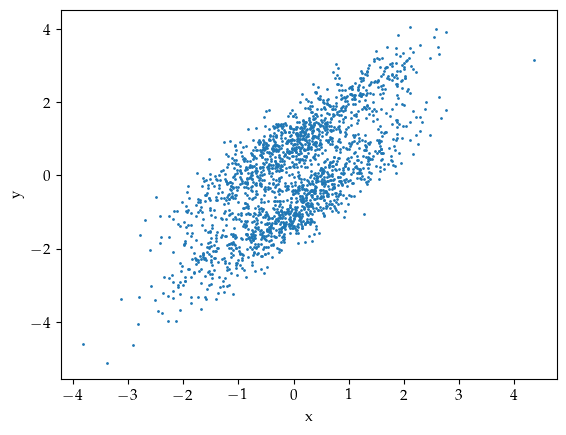

In [8]:
import matplotlib.pyplot as plt
plt.scatter(x, y, s=1)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

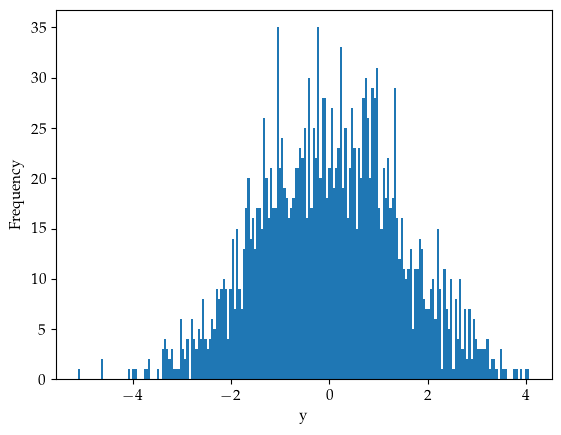

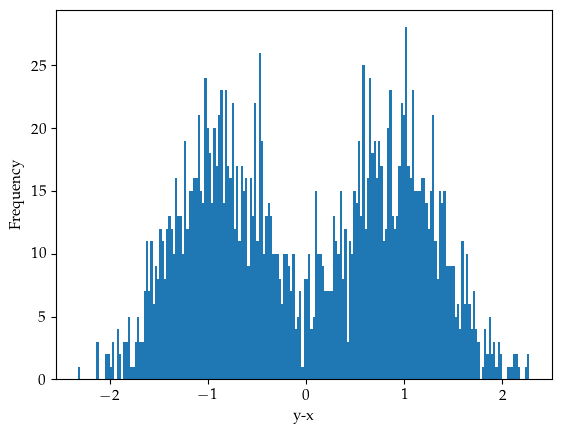

In [9]:
plt.hist(y, bins=200)
plt.xlabel('y')
plt.ylabel('Frequency')
plt.show()

plt.hist(y-x, bins=200)
plt.xlabel('y-x')
plt.ylabel('Frequency')
plt.show()

In [10]:
np.std(x), np.std(y)

(1.0071546579214712, 1.4303866108060235)

In [11]:
std_x = np.std(x)
std_y = np.std(y)

#x = x / std_x
#y = y / std_y
#k = k / std_x

## Use Quantile Regression and CDE -> CP and compare the results

### Setup

In [12]:
from utils.models.basic_architectures import MLP
from utils.models.mdn import MDN
from torch.utils.data import DataLoader, TensorDataset
import torch
from torch.optim import Adam
from tqdm import tqdm

{'a/b/c': 1, 'a/b/d': 2, 'a/e': 3, 'f': 4}


In [13]:
predict_quantile = 0.1

y_space = np.linspace(-5, 5, 1000)
pdf_values = mixture_gaussian_pdf(y_space, -k, +k, std_dev)
pdf_values / pdf_values.sum()
true_y = y_space[np.argmin(np.abs(np.cumsum(pdf_values / pdf_values.sum())-predict_quantile))]

print(f"True quantile: {true_y}")

quantile_grid = torch.arange(0.01, 0.99, 0.001)#torch.tensor([predict_quantile])#
true_quantile = true_y + x
wanted_pos = np.argmin(np.abs(quantile_grid - predict_quantile)).item()
print(f"Wanted pos: {wanted_pos}")

True quantile: -1.2962962962962963
Wanted pos: 90


In [14]:
td = TensorDataset(torch.tensor(x, dtype=torch.float32).unsqueeze(-1), torch.tensor(y, dtype=torch.float32), torch.tensor(true_quantile, dtype=torch.float32))
dl = DataLoader(td, batch_size=256, shuffle=True)
dl_train_no_shuffle = DataLoader(td, batch_size=256, shuffle=False)

td_test = TensorDataset(torch.tensor(x_test, dtype=torch.float32).unsqueeze(-1), torch.tensor(y_test, dtype=torch.float32), torch.tensor(x_test + true_y, dtype=torch.float32))
dl_test = DataLoader(td_test, batch_size=256, shuffle=False)

In [15]:
n_epochs = int(2e5 // len(x))

### QR

In [12]:
mlp = MLP(1, [32, 32], len(quantile_grid), dropout_rate=0, activation='relu')


In [13]:
optimizer = Adam(mlp.parameters(), lr=5e-4)

Loss: 0.2952306568622589: 100%|██████████| 10/10 [00:40<00:00,  4.10s/it]


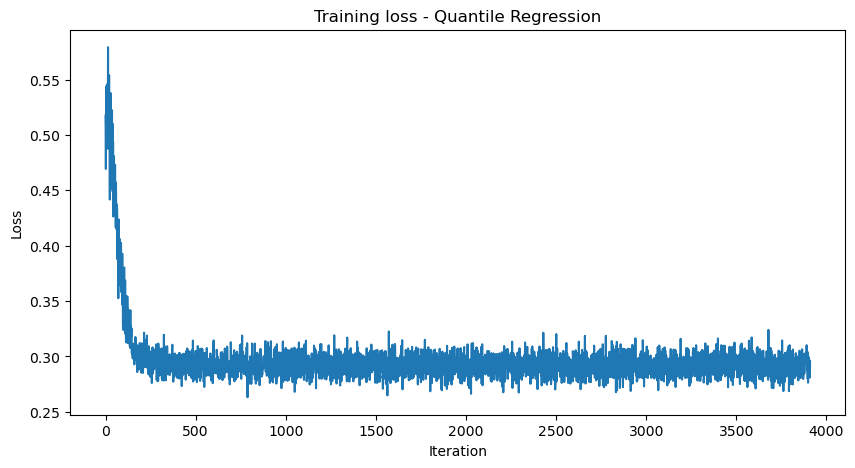

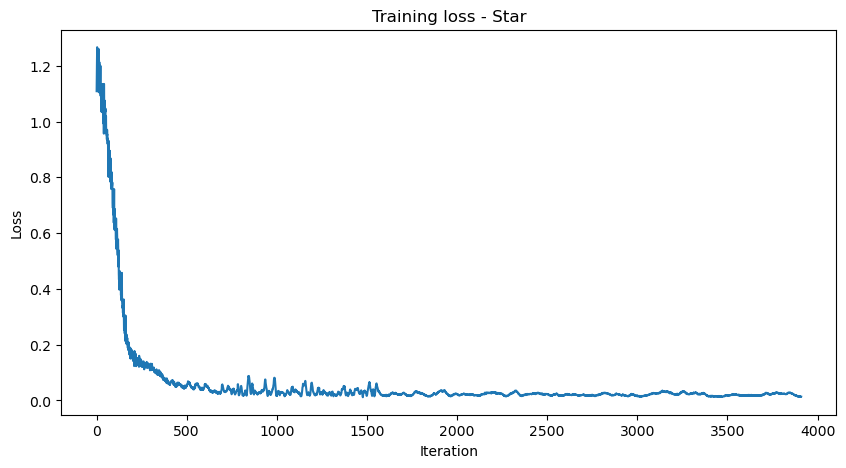

True mean absolute error:
0.013916097


In [16]:
bar = tqdm(range(n_epochs))
losses_list = []
losses_star = [] 
for epoch in bar:
    for x_batch, y_batch, y_star in dl:
        y_hat = mlp(x_batch)
        
        y_hat, _ = torch.sort(y_hat, 1)

        errors = y_batch.view(-1, 1) - y_hat
        
        losses = torch.max((quantile_grid.unsqueeze(0) - 1) * errors, quantile_grid.unsqueeze(0) * errors)
        loss = losses.mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses_list.append(loss.item())
        losses_star.append((y_hat[:, wanted_pos] - y_star).abs().mean().item())
    bar.set_description_str(f"Loss: {loss.item()}")

    if epoch == n_epochs//10:
        optimizer = Adam(mlp.parameters(), lr=5e-4)
    if epoch ==  3* n_epochs//10:
        optimizer = Adam(mlp.parameters(), lr=1e-4)
    if epoch == 4* n_epochs//10:
        optimizer = Adam(mlp.parameters(), lr=5e-5)


plt.figure(figsize=(10, 5))
plt.plot(losses_list)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss - Quantile Regression')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(losses_star)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss - Star')
plt.show()

y_star_differences = []
for x_batch, y_batch, y_star in dl_train_no_shuffle:
    y_hat = mlp(x_batch)
    y_hat, _ = torch.sort(y_hat, 1)
    y_hat = y_hat[:, wanted_pos]
    y_star_differences.append((y_hat - y_star).detach().numpy().reshape(-1))

y_star_differences = np.concatenate(y_star_differences)
print("True mean absolute error:")
print(np.mean(np.abs(y_star_differences)))

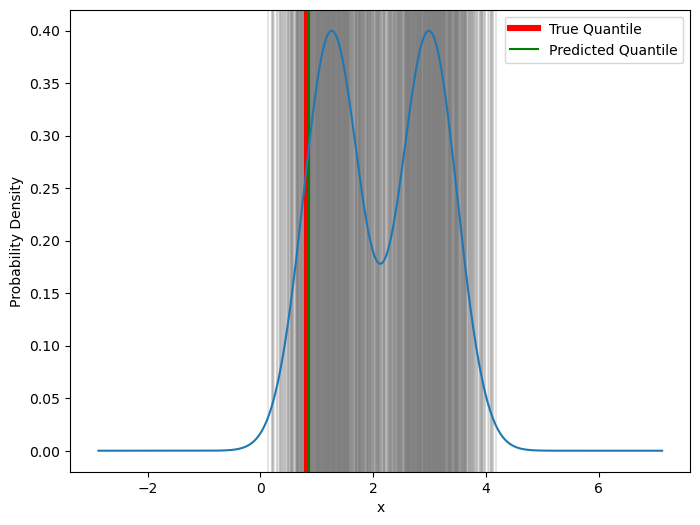

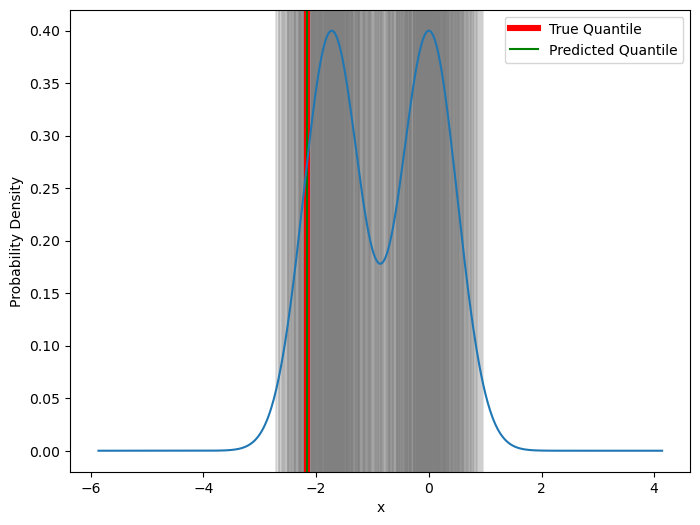

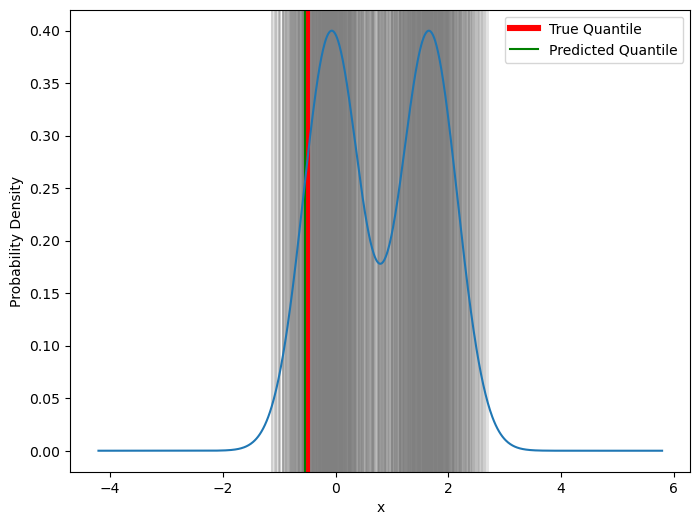

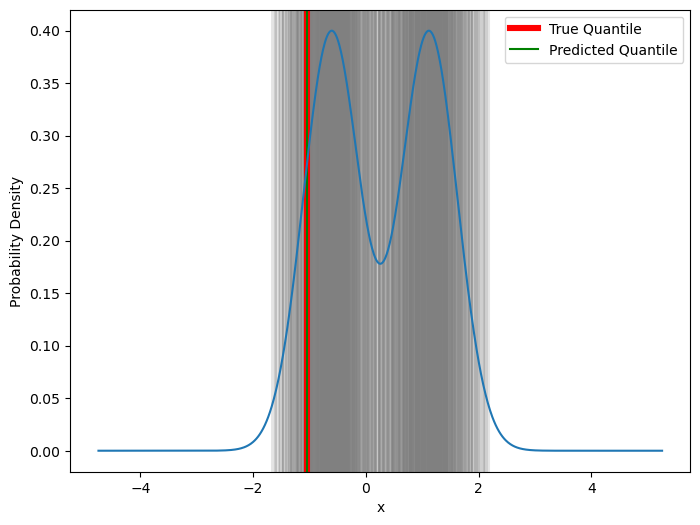

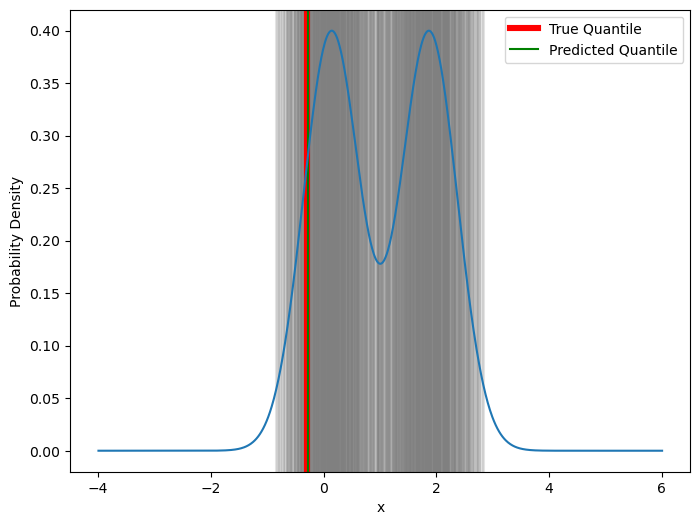

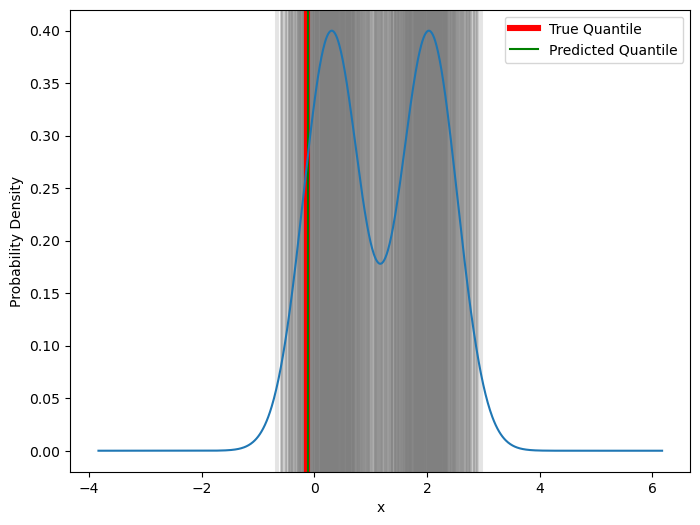

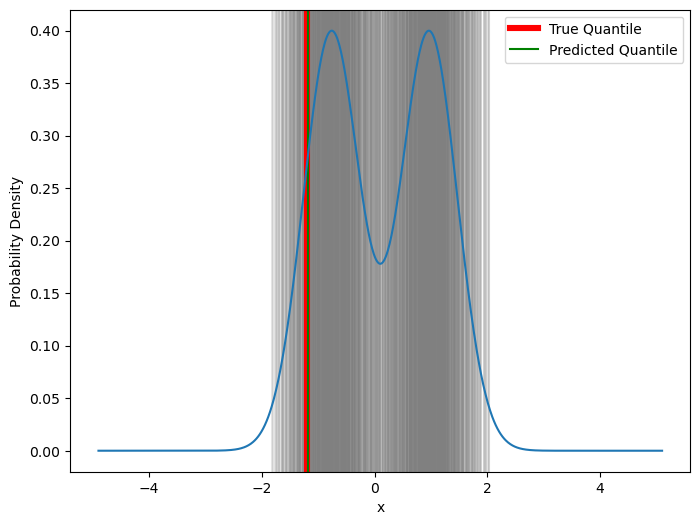

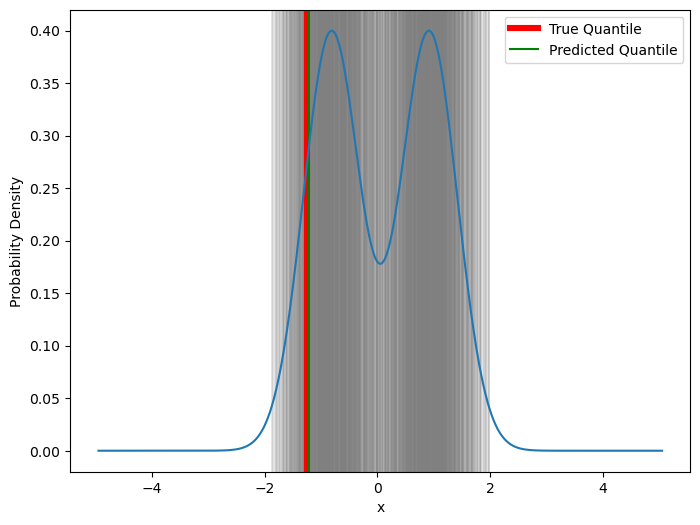

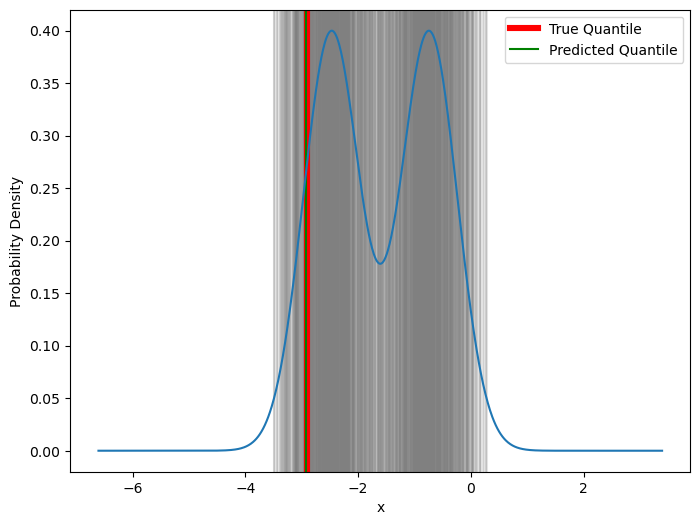

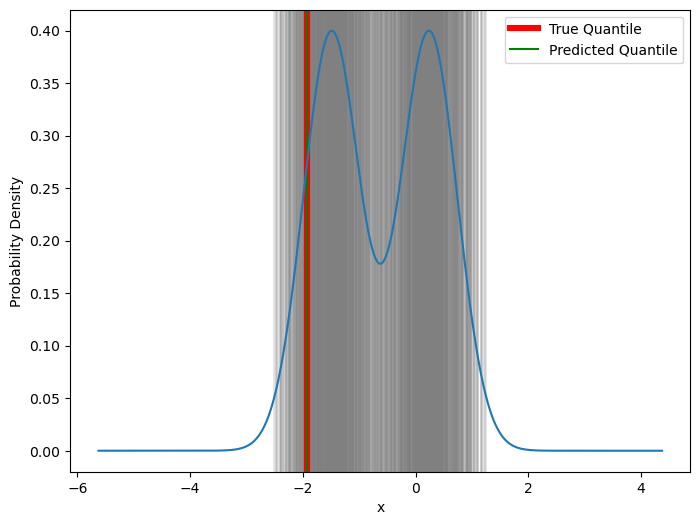

In [17]:
for idx in range(10):
    x_val, y_batch, y_star = td[idx]
    y_hat = mlp(x_val.unsqueeze(0))
    y_hat, _ = torch.sort(y_hat, 1)
    y_hat_wanted = y_hat[:, wanted_pos]

    plt.figure(figsize=(8, 6))
    for i in range(y_hat.shape[1]):
        y_hat_i = y_hat[:, i].detach().numpy()
        plt.axvline(x=y_hat_i, color='gray', alpha=0.2)
    
    
    plt.axvline(x=y_star, color='red', label='True Quantile', lw=4.4)
    plt.axvline(x=y_hat_wanted.detach().numpy(), color='green', label='Predicted Quantile')

    plt.plot(y_space + x_val.item(), pdf_values)
    plt.xlabel('x')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.show()

### Standard MDN

In [20]:
from utils.models.mdn import MDN
from utils.data_module import TrainingDataModule, CustomDataset

In [21]:
ds = CustomDataset(x.reshape(-1, 1), y.reshape(-1, 1))

In [22]:
dm = TrainingDataModule(ds, ds)

In [23]:
mdn = MDN(dm, [32,32], 3, dropout_rate=0, activation_function="relu")
optimizer = Adam(mdn.parameters(), lr=5e-3)

In [24]:
bar = tqdm(range(n_epochs))
for epoch in bar:
    
    for x_batch, y_batch in dm.get_train_dataloader(256):
        
        loss, metric_dict = mdn.training_pass(x_batch, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch == n_epochs//10:
        optimizer = Adam(mdn.parameters(), lr=5e-4)
    if epoch ==  3* n_epochs//10:
        optimizer = Adam(mdn.parameters(), lr=1e-4)
    if epoch == 4* n_epochs//10:
        optimizer = Adam(mdn.parameters(), lr=5e-5)

    bar.set_description_str(f"Loss: {loss.item()}")

Loss: 0.9519196152687073: 100%|██████████| 1000/1000 [00:20<00:00, 47.64it/s]


In [23]:
all_diffs = 0
all_diffs_qr = 0
for x_batch, y_batch, y_star in dl_train_no_shuffle:
    y_star = y_star.numpy()

    quantile = mdn.get_quantile(x_batch, quantile_grid[wanted_pos], y_space = torch.tensor(y_space)).detach().numpy()

    y_hat = mlp(x_batch)
    y_hat, _ = torch.sort(y_hat, 1)
    y_hat_wanted = y_hat[:, wanted_pos].detach().numpy()


    
    all_diffs_qr += np.sum(np.abs((y_hat_wanted - y_star)))
    all_diffs += np.sum(np.abs(y_star - quantile))
print("True mean absolute error:", all_diffs / len(td))
print("True mean absolute error QR:", all_diffs_qr / len(td))

True mean absolute error: 0.008577038503552738
True mean absolute error QR: 0.013916096048355102


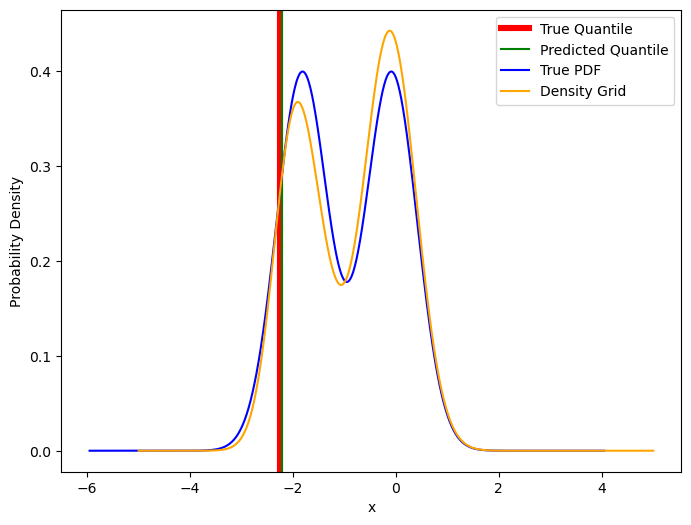

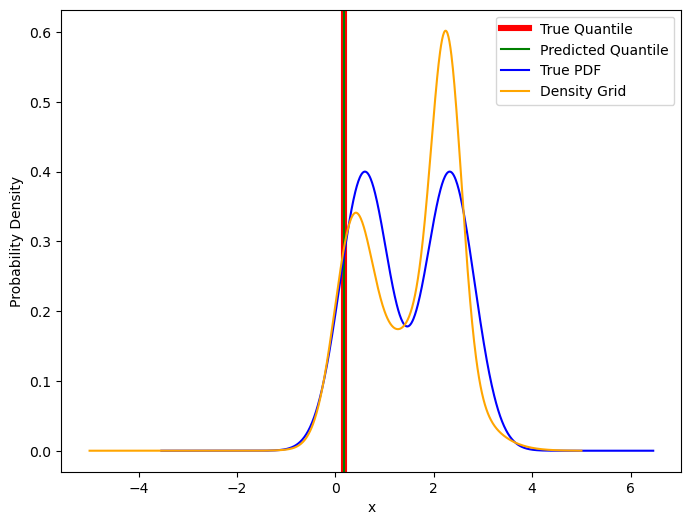

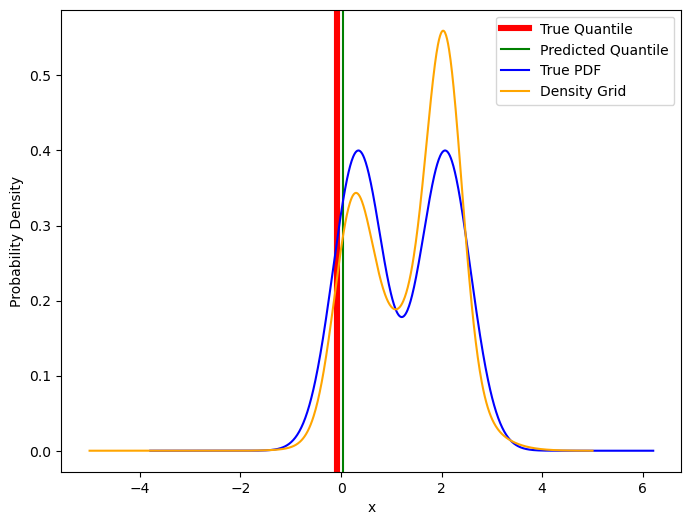

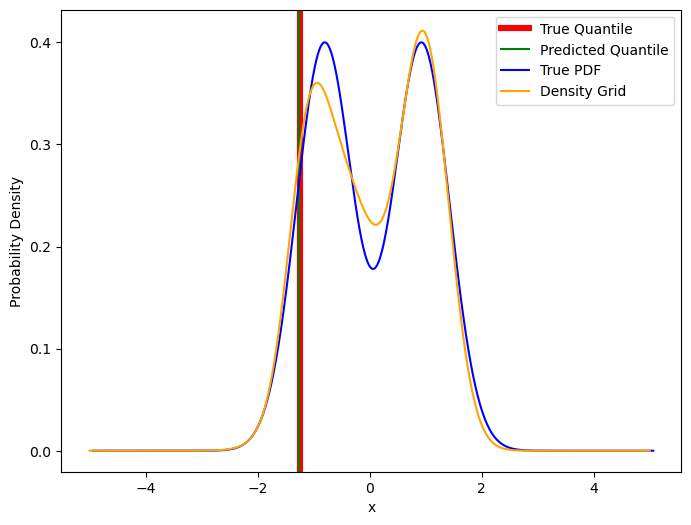

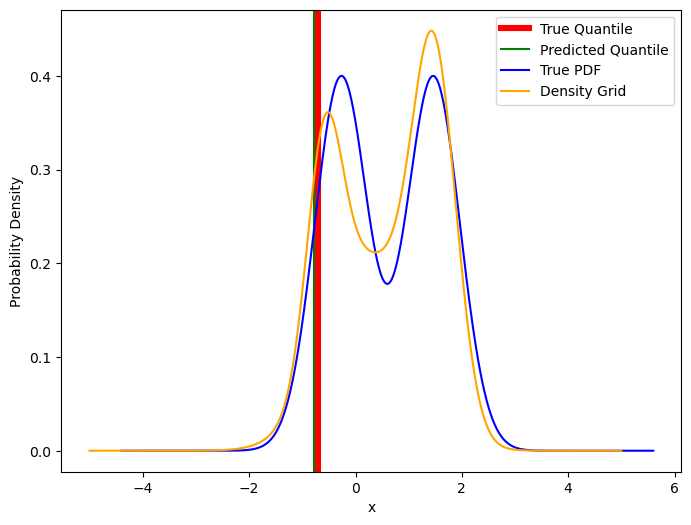

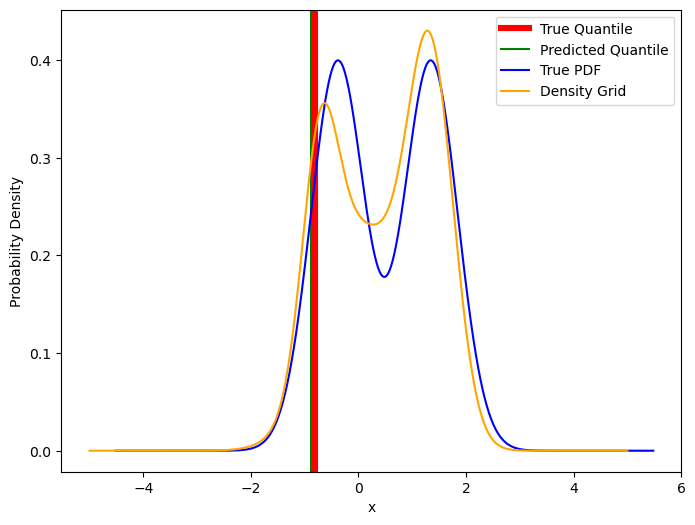

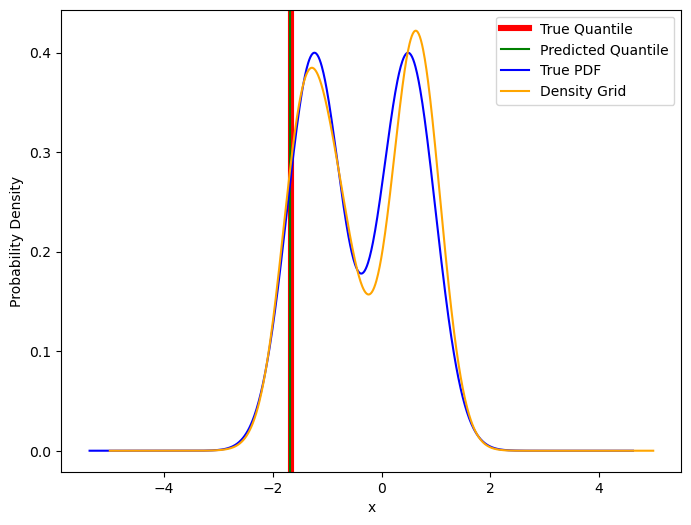

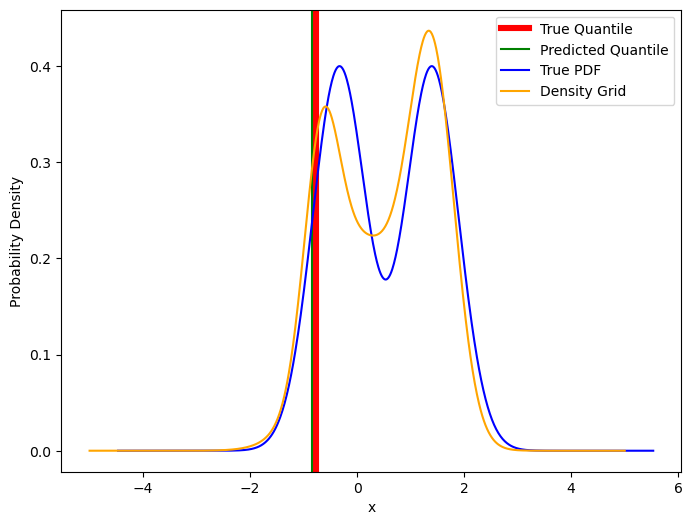

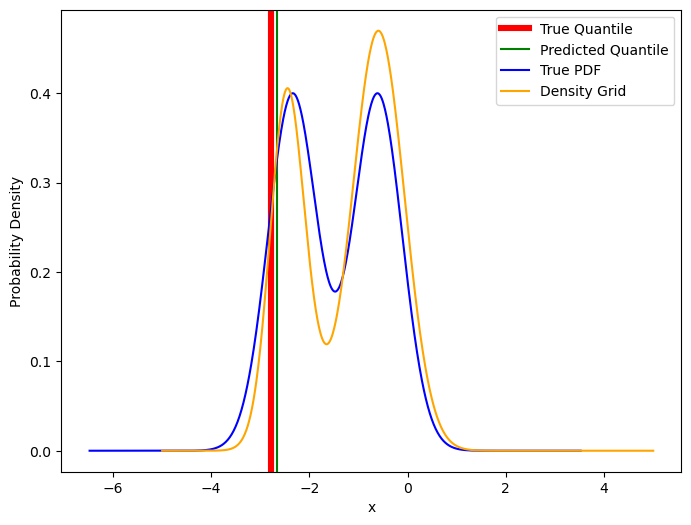

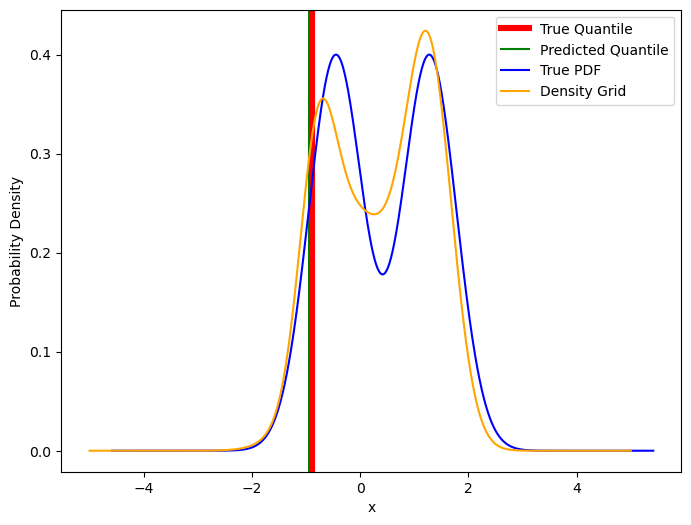

In [25]:

for idx in range(10):
    x_val, y_batch, y_star = td[idx]
    y_hat_wanted = mdn.get_quantile(x_val.unsqueeze(0), quantile_grid[wanted_pos], y_space = torch.tensor(y_space))
    density_grid = mdn.get_density_grid(x_val.unsqueeze(0), y_space = torch.tensor(y_space))[0].detach().numpy()

    plt.figure(figsize=(8, 6))
    
    
    plt.axvline(x=y_star, color='red', label='True Quantile', lw=4.4)
    plt.axvline(x=y_hat_wanted.detach().numpy(), color='green', label='Predicted Quantile')

    plt.plot(y_space + x_val.item(), pdf_values, label='True PDF', color='blue')
    plt.plot(y_space, density_grid, label='Density Grid', color='orange')
    plt.xlabel('x')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.show()

## MDN Quantile Regression Hybrid

In [16]:
from utils.models.mdn import MDN
from utils.data_module import TrainingDataModule, CustomDataset

ds = CustomDataset(x.reshape(-1, 1), y.reshape(-1, 1))
dm = TrainingDataModule(ds, ds)

In [17]:
def evaluate(mdn, by_quantile_grid = False):
    all_diffs = 0
    for x_batch, y_batch, y_star in dl_train_no_shuffle:
        y_star = y_star.numpy()
        if by_quantile_grid:
            n_quantiles = mdn.n_distributions
            quantile_grid = torch.linspace(1.0/(n_quantiles+1), n_quantiles/(n_quantiles+1), n_quantiles)
            index_we_want = torch.argmin(torch.abs(quantile_grid - predict_quantile)).item()

            mu = mdn.forward(x_batch)["mu"]
            mu = mu.flatten(1)
            mu, _ = torch.sort(mu, -1)

            quantile = mu[:, index_we_want].detach().numpy()

        else:
            quantile = mdn.get_quantile(x_batch, predict_quantile, y_space = torch.tensor(y_space)).detach().numpy()
        all_diffs += np.sum(np.abs(y_star - quantile))

    print(f"True mean absolute error: {all_diffs / len(td)}; By quantile grid: {by_quantile_grid}")

In [18]:
def show_plots(mdn, num_plots: int):

    for idx in range(num_plots):
        x_val, y_batch, y_star = td[idx]

        dist_params = mdn.forward(x_val.unsqueeze(0))
        mu = dist_params["mu"].flatten()
        y_hat_wanted = mdn.get_quantile(x_val.unsqueeze(0), quantile_grid[wanted_pos], y_space = torch.tensor(y_space))
        density_grid = mdn.get_density_grid(x_val.unsqueeze(0), y_space = torch.tensor(y_space))[0].detach().numpy()

        plt.figure(figsize=(8, 6))
        
        for i in range(mu.shape[0]):
            y_hat_i = mu[i].detach().numpy()
            plt.axvline(x=y_hat_i, color='gray', alpha=0.2)
        
        plt.axvline(x=y_star, color='red', label='True Quantile', lw=4.4)
        plt.axvline(x=y_hat_wanted.detach().numpy(), color='green', label='Predicted Quantile')

        plt.plot(y_space + x_val.item(), pdf_values, label='True PDF', color='blue')
        plt.plot(y_space, density_grid, label='Density Grid', color='orange')
        plt.xlabel('x')
        plt.ylabel('Probability Density')
        plt.legend()
        plt.show()

In [19]:
class MDNHybridLossScheduler:

    def __init__(self, initial_pb_weight = 1.0, initial_nll_weight = 0.0, mode="linear", stepsize=0.001) -> None:
        
        self.pb_weight = initial_pb_weight
        self.nll_weight = initial_nll_weight
        self.mode = mode
        self.stepsize = stepsize

    def get_loss_hyperparameters(self):

        return {
            "pinball_loss_weight": self.pb_weight,
            "nll_loss_weight": self.nll_weight
        }
    
    def step(self):
        if self.mode == "linear":
            self.pb_weight -= self.stepsize
            self.nll_weight += self.stepsize

        # Clip the values to be between 0 and 1
        self.pb_weight = np.clip(self.pb_weight, 0, 1)
        self.nll_weight = np.clip(self.nll_weight, 0, 1)

        return self.get_loss_hyperparameters()

In [20]:
noise_weight = 0.12

#### Start with only Pinball

Loss: 0.31600096821784973:   5%|▌         | 5/100 [00:00<00:04, 21.16it/s]

{'pinball_loss_weight': 0.9976000000000003, 'nll_loss_weight': 0.0024}


Loss: 0.3583908677101135:  14%|█▍        | 14/100 [00:00<00:03, 23.49it/s] 

{'pinball_loss_weight': 0.9736000000000029, 'nll_loss_weight': 0.026400000000000055}


Loss: 0.3577316105365753:  26%|██▌       | 26/100 [00:01<00:02, 25.34it/s] 

{'pinball_loss_weight': 0.9496000000000056, 'nll_loss_weight': 0.05040000000000019}


Loss: 0.3626691699028015:  35%|███▌      | 35/100 [00:01<00:02, 27.00it/s] 

{'pinball_loss_weight': 0.9256000000000082, 'nll_loss_weight': 0.07440000000000005}


Loss: 0.3844856917858124:  44%|████▍     | 44/100 [00:01<00:02, 27.41it/s] 

{'pinball_loss_weight': 0.9016000000000108, 'nll_loss_weight': 0.09839999999999963}


Loss: 0.4248756170272827:  53%|█████▎    | 53/100 [00:02<00:02, 21.92it/s] 

{'pinball_loss_weight': 0.8776000000000135, 'nll_loss_weight': 0.1223999999999992}


Loss: 0.4274214506149292:  65%|██████▌   | 65/100 [00:02<00:01, 23.24it/s] 

{'pinball_loss_weight': 0.8536000000000161, 'nll_loss_weight': 0.14639999999999878}


Loss: 0.44978731870651245:  76%|███████▌  | 76/100 [00:03<00:00, 27.39it/s]

{'pinball_loss_weight': 0.8296000000000188, 'nll_loss_weight': 0.17039999999999836}


Loss: 0.48227590322494507:  86%|████████▌ | 86/100 [00:03<00:00, 28.41it/s]

{'pinball_loss_weight': 0.8056000000000214, 'nll_loss_weight': 0.19439999999999794}


Loss: 0.5030633211135864:  96%|█████████▌| 96/100 [00:03<00:00, 27.89it/s] 

{'pinball_loss_weight': 0.781600000000024, 'nll_loss_weight': 0.2183999999999975}


Loss: 0.49747055768966675: 100%|██████████| 100/100 [00:03<00:00, 25.57it/s]


True mean absolute error: 0.09548465853733128; By quantile grid: False


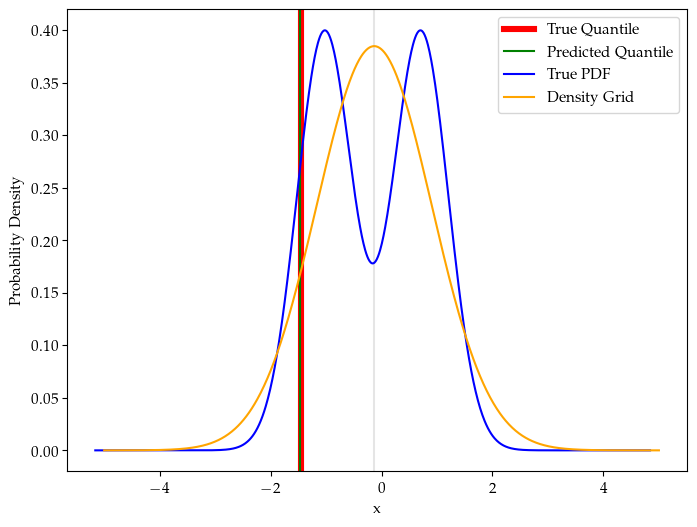

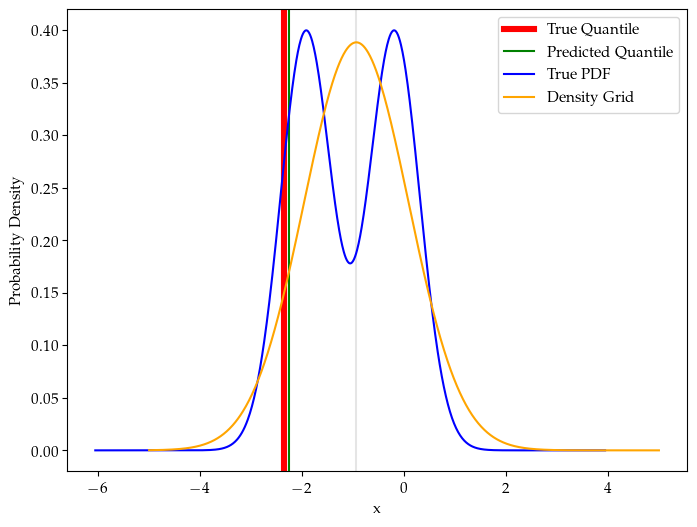

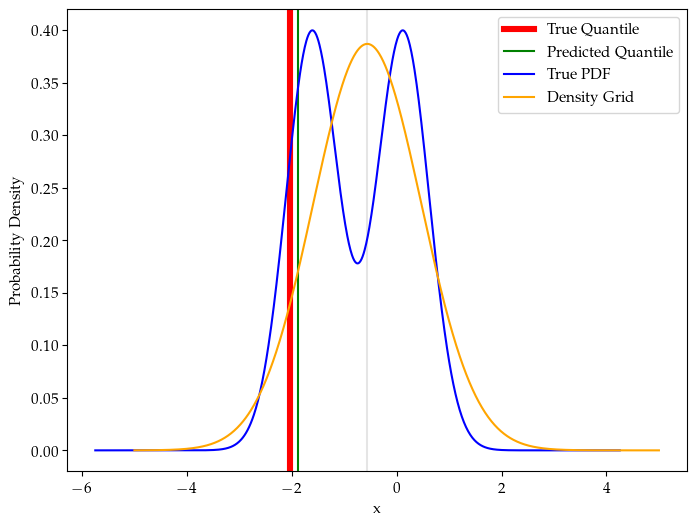

In [21]:
mdn = MDN(dm, [32,32], 1, dropout_rate=0, activation_function="relu")
optimizer = Adam(mdn.parameters(), lr=5e-3)

loss_scheduler = MDNHybridLossScheduler(1.0, 0.0, stepsize=0.0003)

bar = tqdm(range(n_epochs))
for epoch in bar:

    for x_batch, y_batch in dm.get_train_dataloader(256):

        x_batch += torch.randn_like(x_batch) * noise_weight
        y_batch += torch.randn_like(y_batch) * noise_weight

        loss, metric_dict = mdn.training_pass(x_batch, y_batch, **loss_scheduler.step())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if epoch % (n_epochs//10) == 0:
        print(loss_scheduler.get_loss_hyperparameters())

    if epoch == n_epochs // 10:
        optimizer = Adam(mdn.parameters(), lr=5e-4)
    if epoch == 3 * n_epochs // 10:
        optimizer = Adam(mdn.parameters(), lr=1e-4)
    if epoch == 4 * n_epochs // 10:
        optimizer = Adam(mdn.parameters(), lr=5e-5)

    bar.set_description_str(f"Loss: {loss.item()}")

evaluate(mdn)

show_plots(mdn, 3)

#### Without Pinball Regularization

Loss: 0.963956892490387:   1%|▏         | 56/4000 [00:00<00:14, 280.89it/s] 

{'pinball_loss_weight': 0.0, 'nll_loss_weight': 1.0}


Loss: 0.6204714179039001:  11%|█▏        | 455/4000 [00:01<00:10, 338.29it/s]

{'pinball_loss_weight': 0.0, 'nll_loss_weight': 1.0}


Loss: 0.7278767228126526:  21%|██▏       | 858/4000 [00:02<00:10, 300.57it/s] 

{'pinball_loss_weight': 0.0, 'nll_loss_weight': 1.0}


Loss: 0.5921199917793274:  31%|███       | 1235/4000 [00:03<00:08, 331.29it/s] 

{'pinball_loss_weight': 0.0, 'nll_loss_weight': 1.0}


Loss: 0.5836253762245178:  41%|████      | 1632/4000 [00:05<00:08, 293.54it/s] 

{'pinball_loss_weight': 0.0, 'nll_loss_weight': 1.0}


Loss: 0.6809470653533936:  52%|█████▏    | 2063/4000 [00:06<00:05, 328.16it/s] 

{'pinball_loss_weight': 0.0, 'nll_loss_weight': 1.0}


Loss: 0.5007979869842529:  62%|██████▏   | 2467/4000 [00:07<00:04, 322.27it/s] 

{'pinball_loss_weight': 0.0, 'nll_loss_weight': 1.0}


Loss: 0.5578843951225281:  71%|███████   | 2841/4000 [00:09<00:03, 318.37it/s] 

{'pinball_loss_weight': 0.0, 'nll_loss_weight': 1.0}


Loss: 0.6105874180793762:  81%|████████  | 3232/4000 [00:10<00:02, 310.08it/s] 

{'pinball_loss_weight': 0.0, 'nll_loss_weight': 1.0}


Loss: 0.6710418462753296:  91%|█████████ | 3631/4000 [00:11<00:01, 301.13it/s] 

{'pinball_loss_weight': 0.0, 'nll_loss_weight': 1.0}


Loss: 0.5617601275444031: 100%|██████████| 4000/4000 [00:12<00:00, 316.19it/s] 


True mean absolute error: 0.21014590274225603; By quantile grid: False


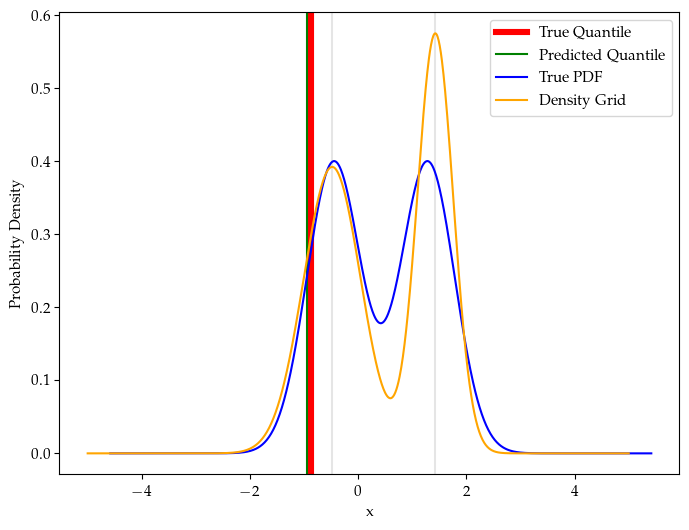

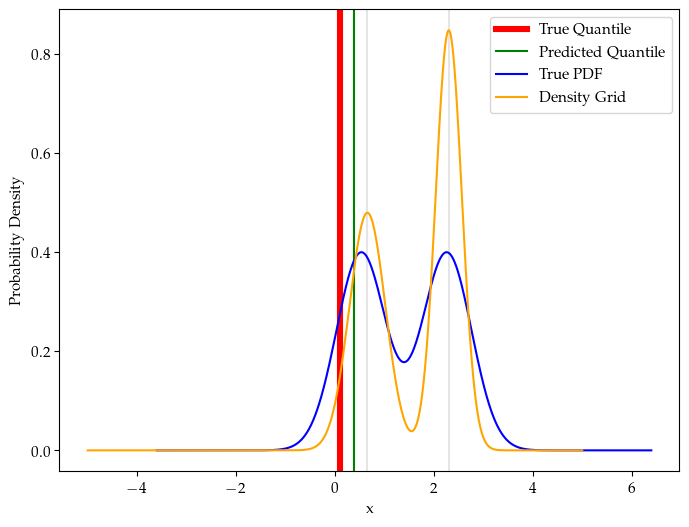

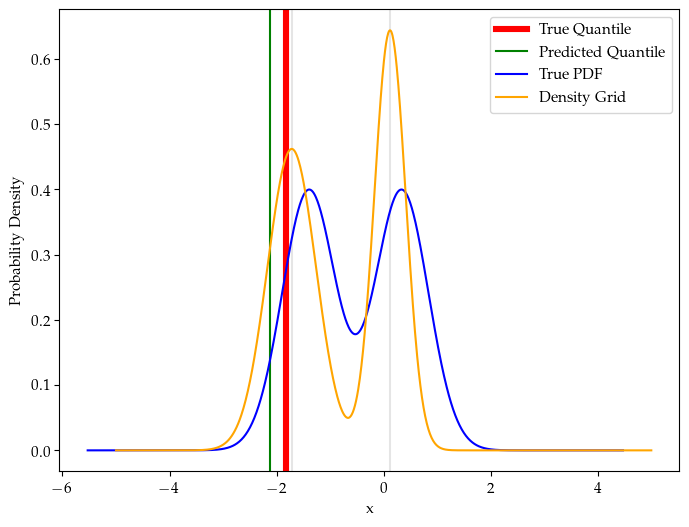

In [22]:
mdn = MDN(dm, [16, 16], 2, dropout_rate=0, activation_function="relu")
optimizer = Adam(mdn.parameters(), lr=5e-3)

loss_scheduler = MDNHybridLossScheduler(0.0, 1.0, mode="constant")

bar = tqdm(range(n_epochs))
for epoch in bar:

    for x_batch, y_batch in dm.get_train_dataloader(256):

        x_batch += torch.randn_like(x_batch) * noise_weight
        y_batch += torch.randn_like(y_batch) * noise_weight

        loss, metric_dict = mdn.training_pass(x_batch, y_batch, **loss_scheduler.step())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if epoch % (n_epochs//10) == 0:
        print(loss_scheduler.get_loss_hyperparameters())

    if epoch == n_epochs // 10:
        optimizer = Adam(mdn.parameters(), lr=5e-4)
    if epoch == 3 * n_epochs // 10:
        optimizer = Adam(mdn.parameters(), lr=1e-4)
    if epoch == 4 * n_epochs // 10:
        optimizer = Adam(mdn.parameters(), lr=5e-5)

    bar.set_description_str(f"Loss: {loss.item()}")

evaluate(mdn)

show_plots(mdn, 3)

#### Only Pinball and force distributions

In [22]:
mdn = MDN(
    dm,
    [32, 32],
    1000,
    dropout_rate=0,
    activation_function="relu",
    force_equal_std=True, #!!
    force_equal_weights=True, #!!
)
optimizer = Adam(mdn.parameters(), lr=5e-3)

loss_scheduler = MDNHybridLossScheduler(1.0, 0.0, mode = "constant")

bar = tqdm(range(n_epochs))
for epoch in bar:

    for x_batch, y_batch in dm.get_train_dataloader(256):

        x_batch += torch.randn_like(x_batch) * noise_weight
        y_batch += torch.randn_like(y_batch) * noise_weight

        loss, metric_dict = mdn.training_pass(x_batch, y_batch, **loss_scheduler.step())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % (n_epochs // 10) == 0:
        print(loss_scheduler.get_loss_hyperparameters())

    if epoch == n_epochs // 10:
        optimizer = Adam(mdn.parameters(), lr=5e-4)
    if epoch == 3 * n_epochs // 10:
        optimizer = Adam(mdn.parameters(), lr=1e-4)
    if epoch == 4 * n_epochs // 10:
        optimizer = Adam(mdn.parameters(), lr=5e-5)

    bar.set_description_str(f"Loss: {loss.item()}")

evaluate(mdn)
evaluate(mdn, by_quantile_grid=True)


show_plots(mdn, 3)

Loss: 0.25504687428474426:   1%|          | 6/1000 [00:00<00:19, 50.50it/s]

{'pinball_loss_weight': 1.0, 'nll_loss_weight': 0.0}


Loss: 0.18058975040912628:  11%|█         | 107/1000 [00:02<00:20, 43.99it/s]

{'pinball_loss_weight': 1.0, 'nll_loss_weight': 0.0}


Loss: 0.1817660927772522:  20%|██        | 200/1000 [00:04<00:17, 45.86it/s] 


KeyboardInterrupt: 

### Epistemic Uncertainty Thru Aleatoric and Recalibration

In [22]:
confidence_grid = torch.linspace(0.03, 1, 50)
y_space = np.linspace(-3, 3, 2048)
pdf_values = mixture_gaussian_pdf(y_space, -k, +k, std_dev)

In [23]:
scaling_factor = (len(y_space)/(y_space.max() - y_space.min())) / (2**.5)
scaling_factor

241.3591146450082

In [24]:
y_space.shape

(2048,)

In [25]:
required_ps = []
for x, y, y_star in dl_test:

    required_p = mdn.get_required_conformal_p_values(x, y, torch.tensor(y_space))
    required_ps.append(required_p)
required_ps = torch.cat(required_ps, 0)

In [26]:
required_p.shape

torch.Size([208])

In [31]:
calibrated_confidence_grid = torch.quantile(required_ps.float(), confidence_grid)

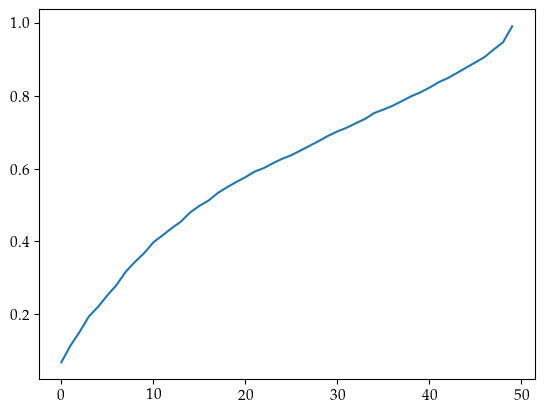

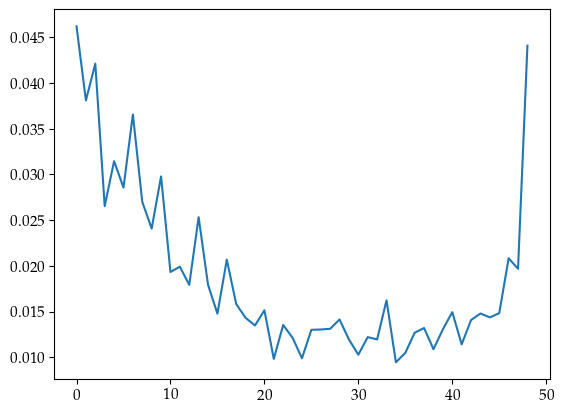

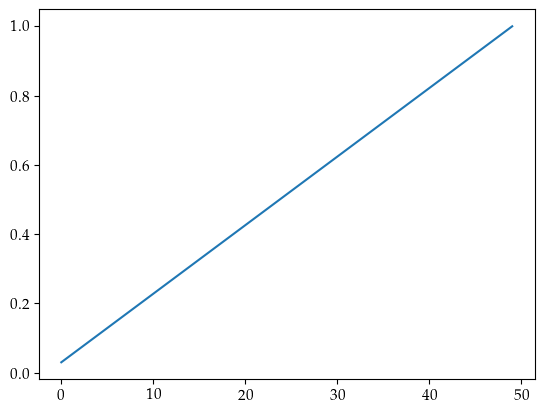

In [32]:
plt.plot(calibrated_confidence_grid.detach().numpy())
plt.show()

grad = calibrated_confidence_grid[1:] - calibrated_confidence_grid[:-1]
plt.plot(grad.detach().numpy())
plt.show()

plt.plot(confidence_grid.detach().numpy())
plt.show()

In [33]:
for x, y, y_star in dl_test:

    hdr_before = mdn.get_hdr(x, confidence_grid, torch.tensor(y_space))
    hdr_after = mdn.get_hdr(x, calibrated_confidence_grid, torch.tensor(y_space))
    density_grid = mdn.get_density_grid(x, torch.tensor(y_space))

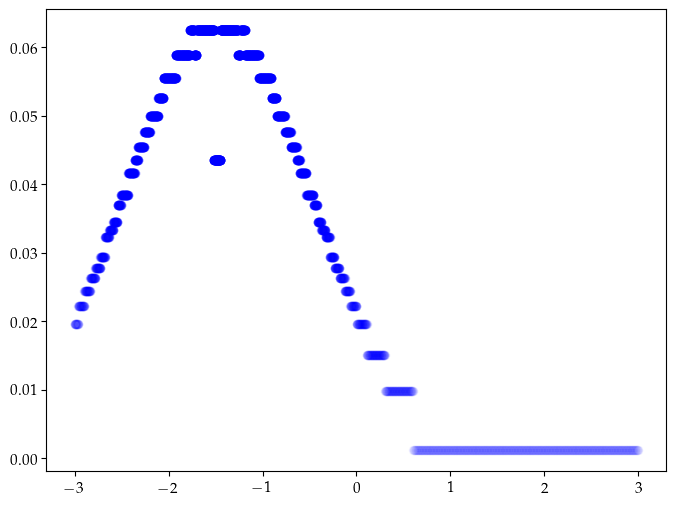

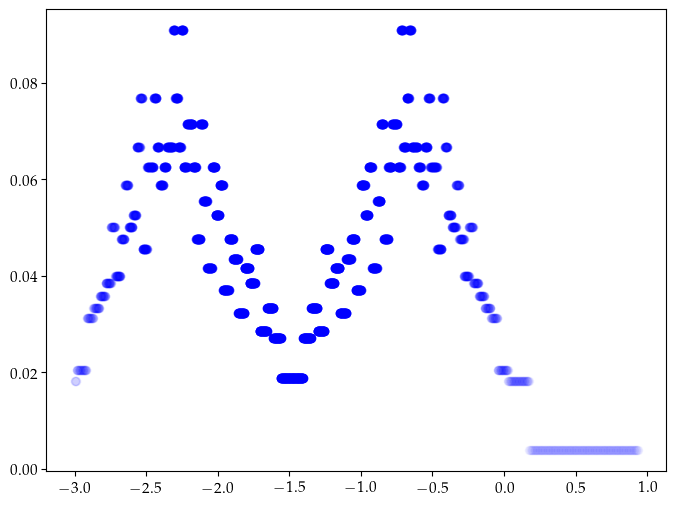

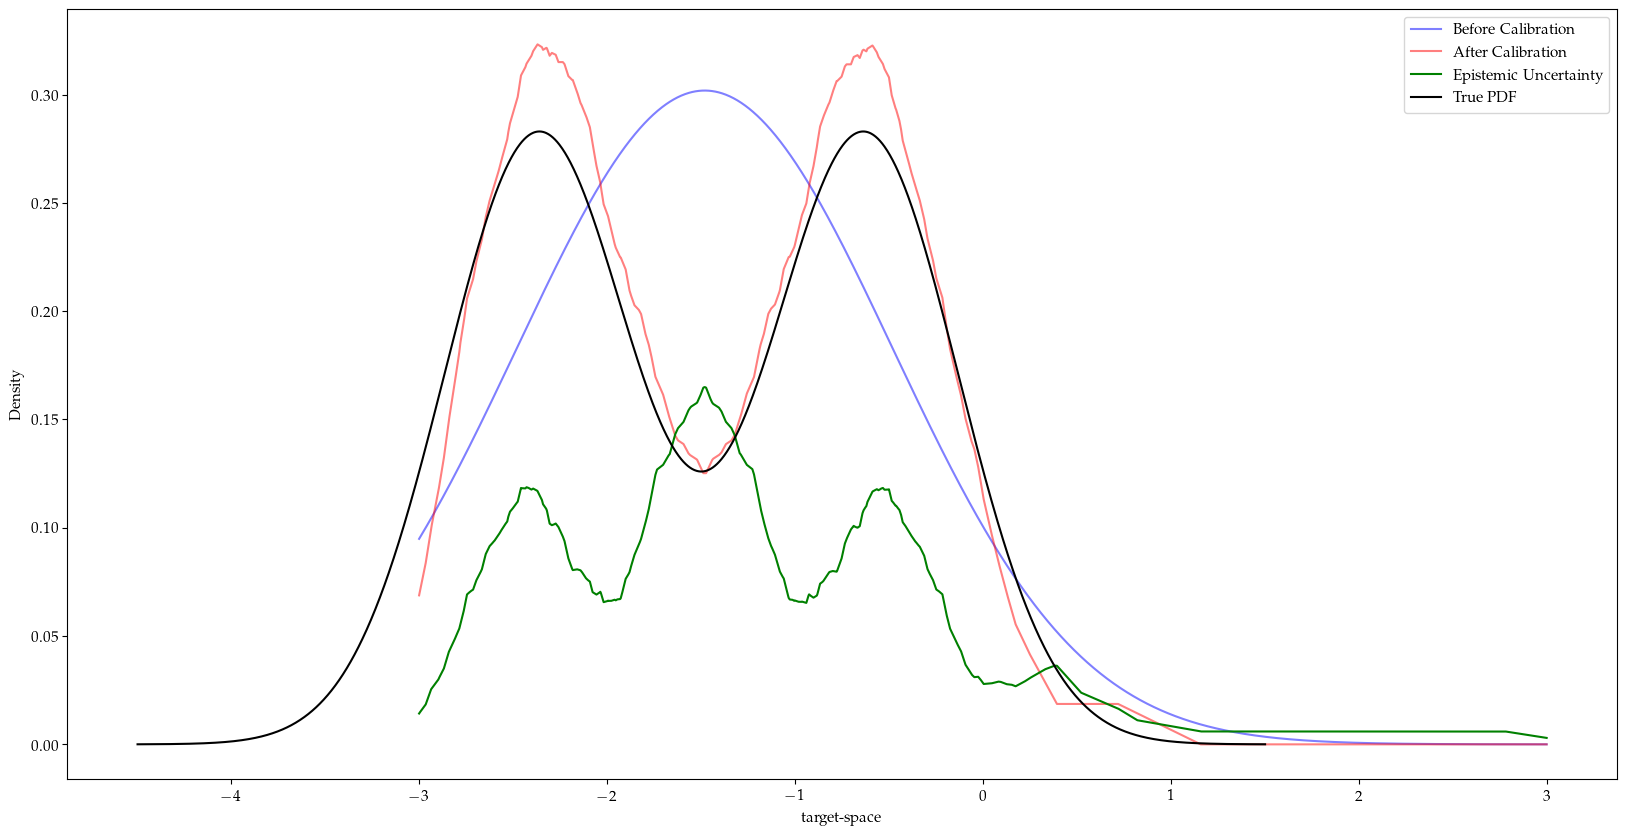

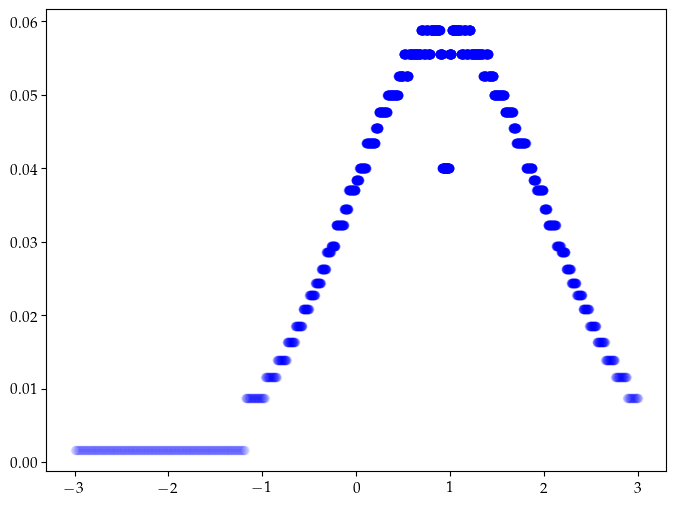

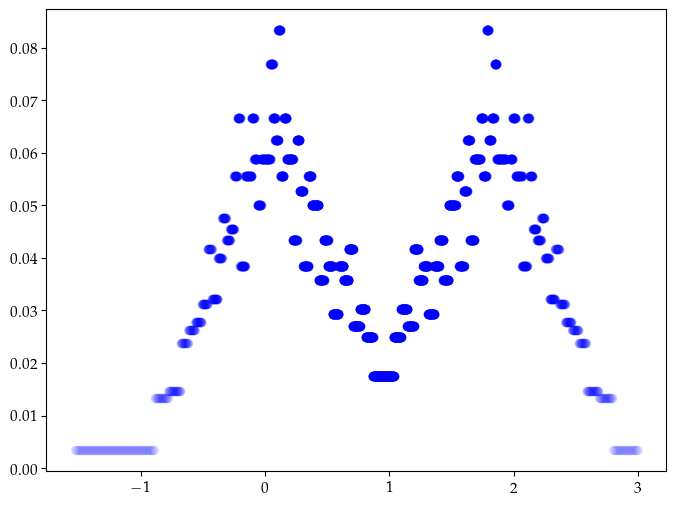

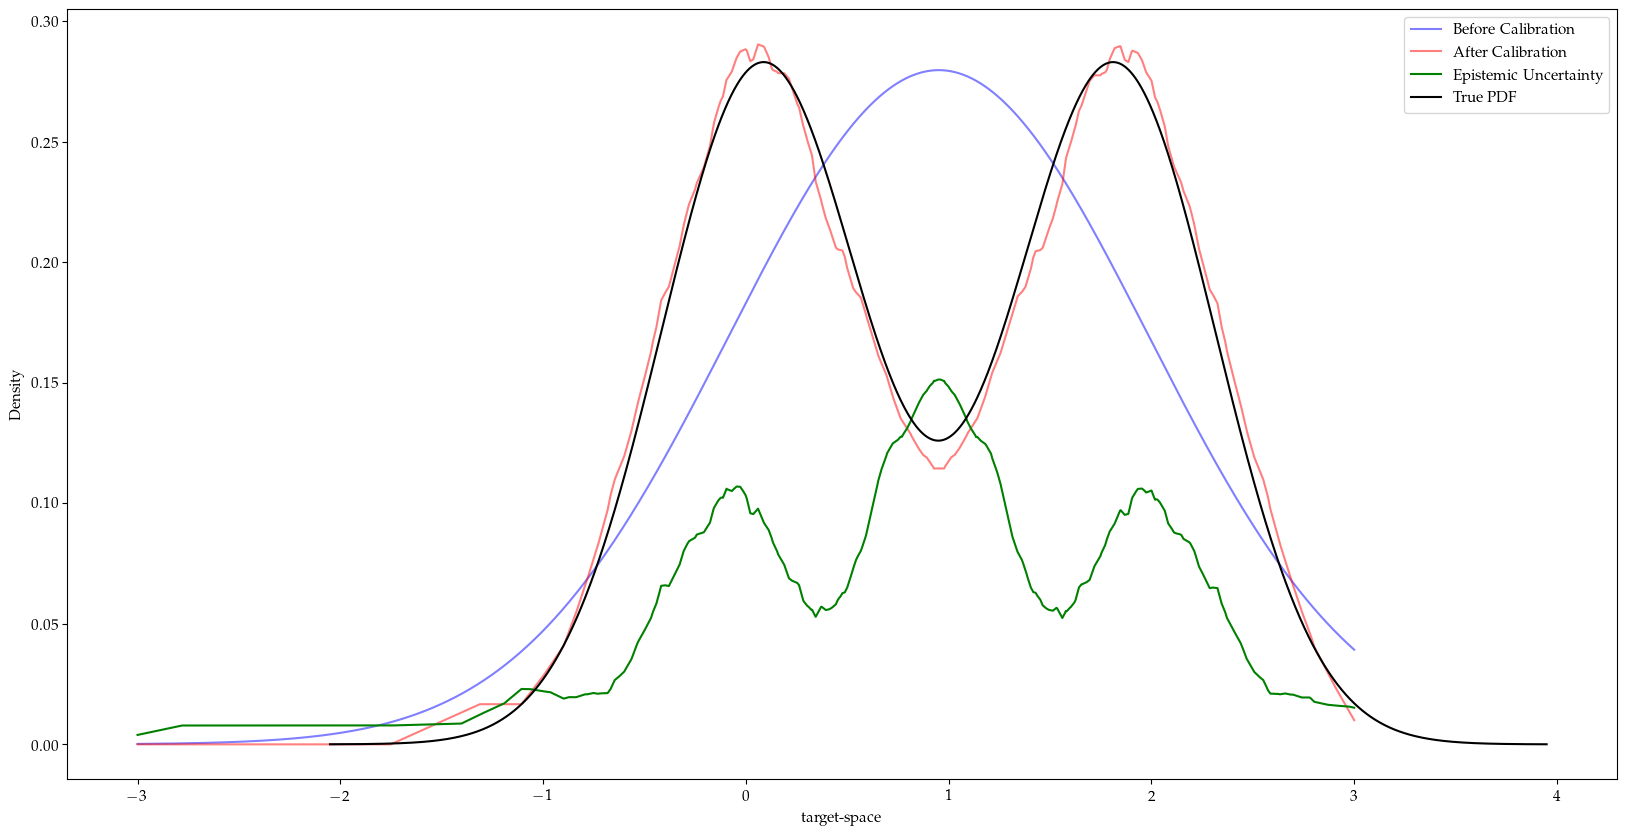

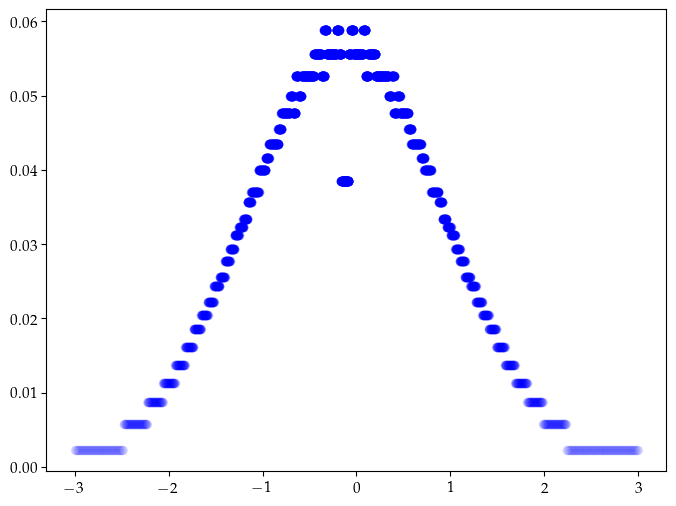

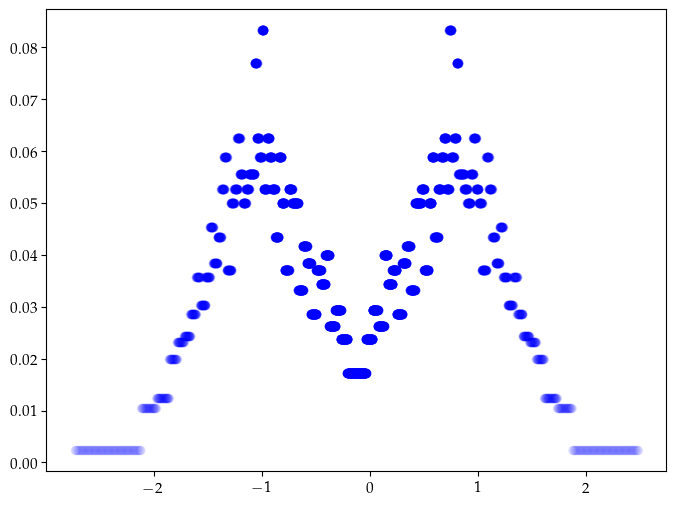

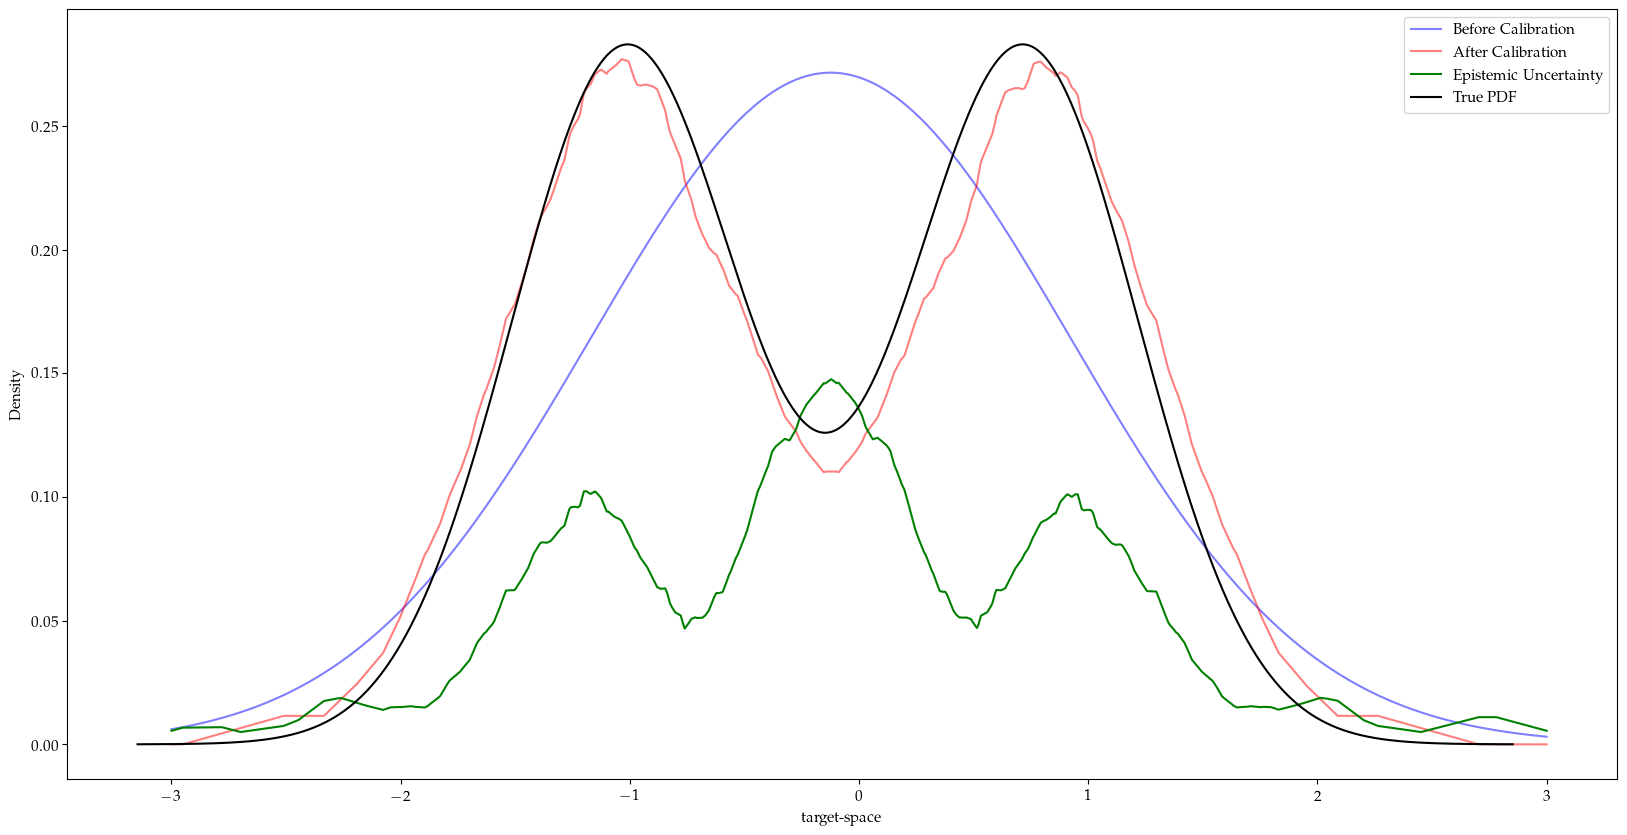

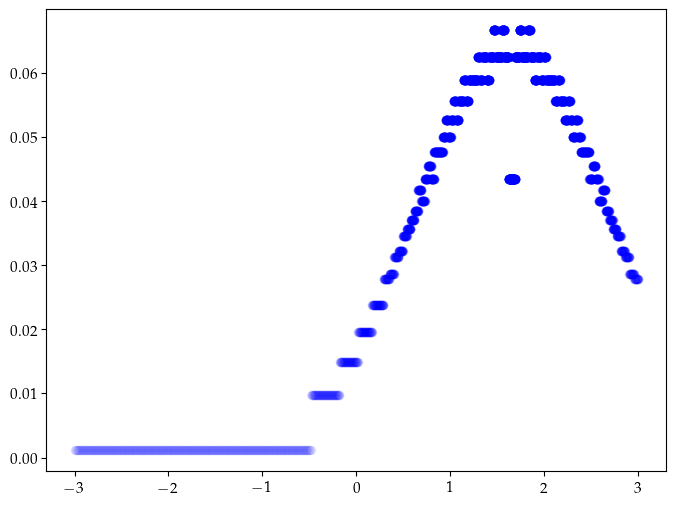

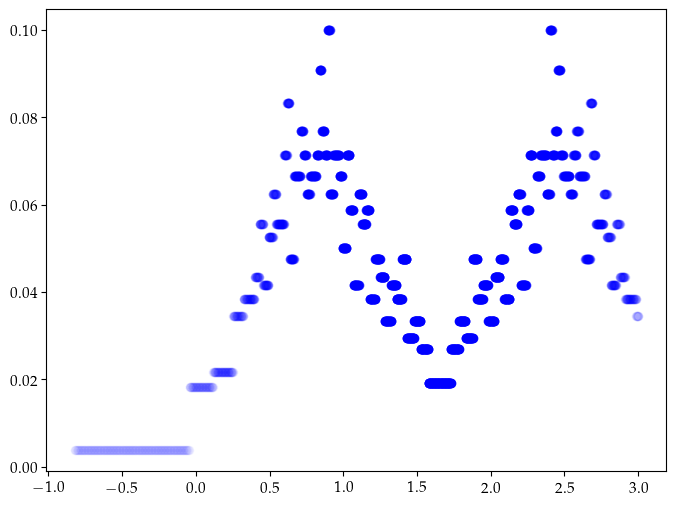

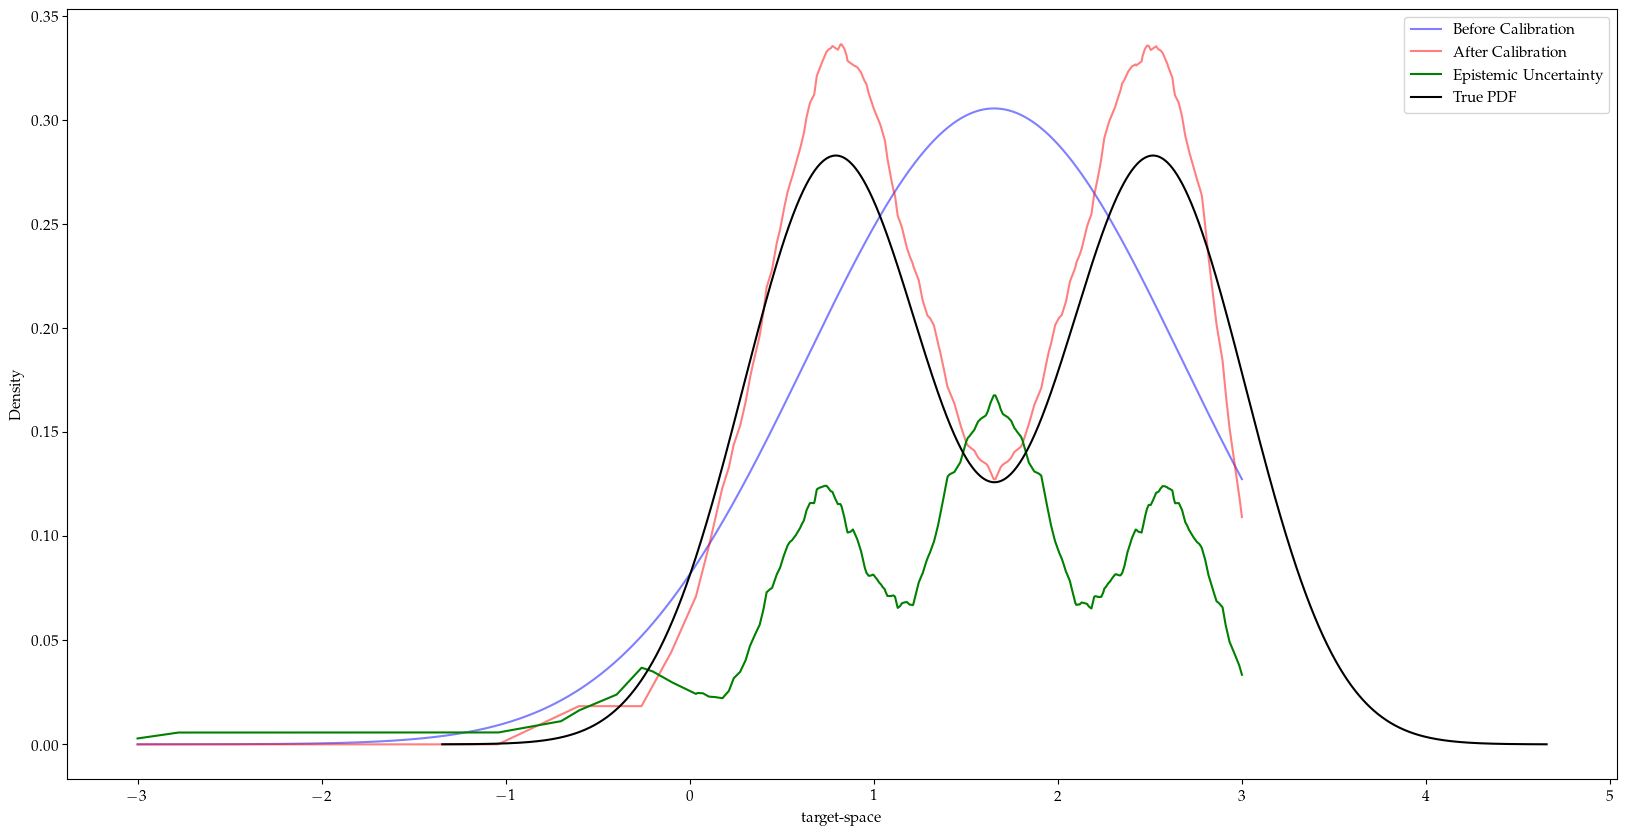

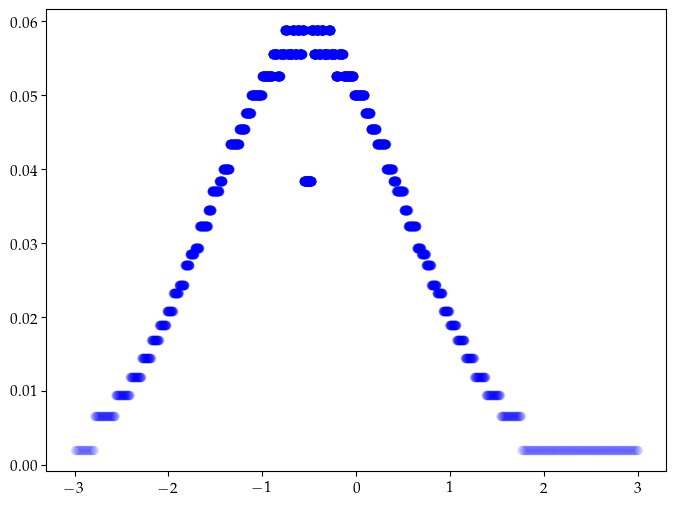

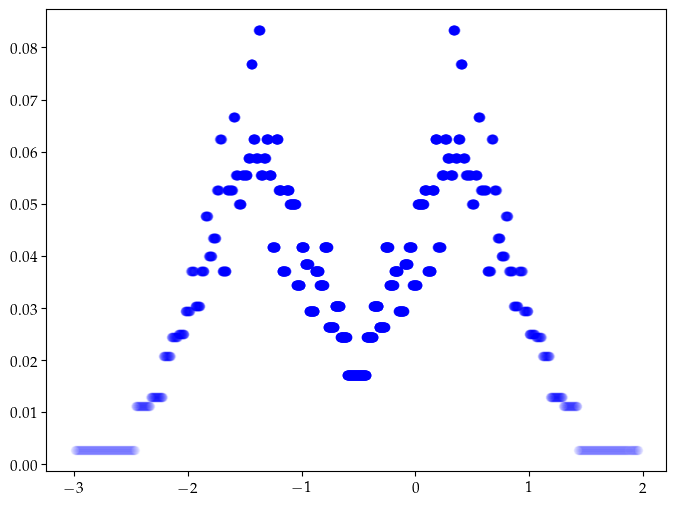

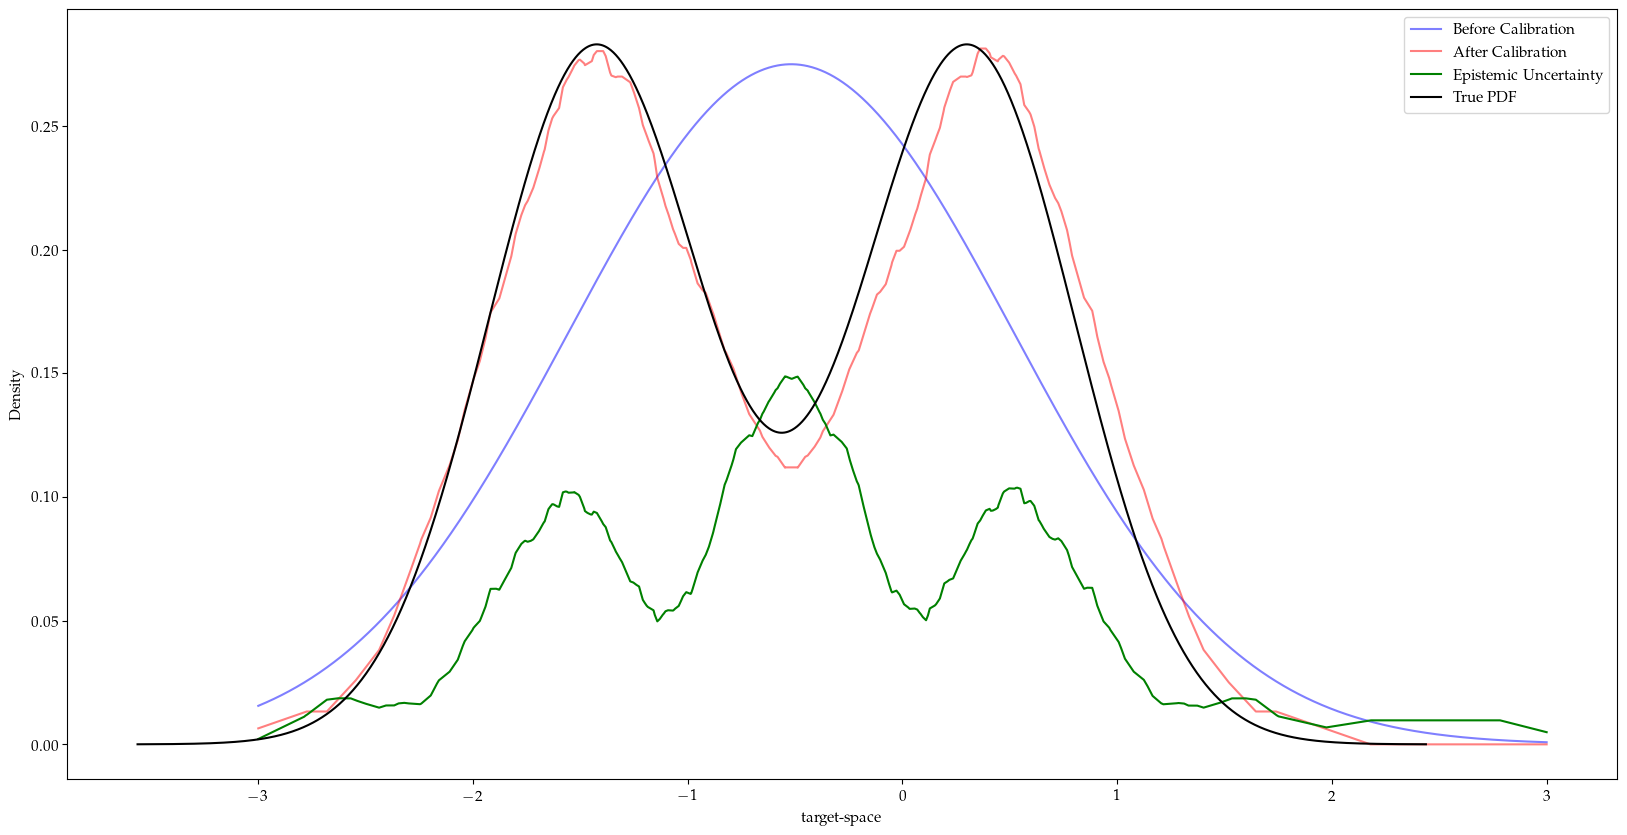

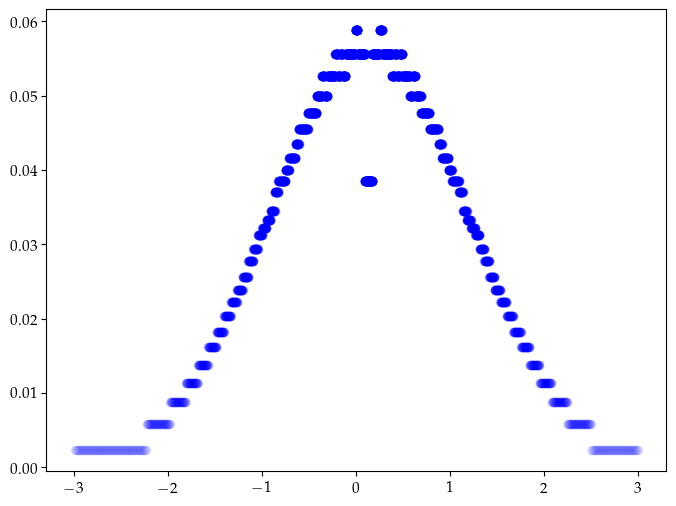

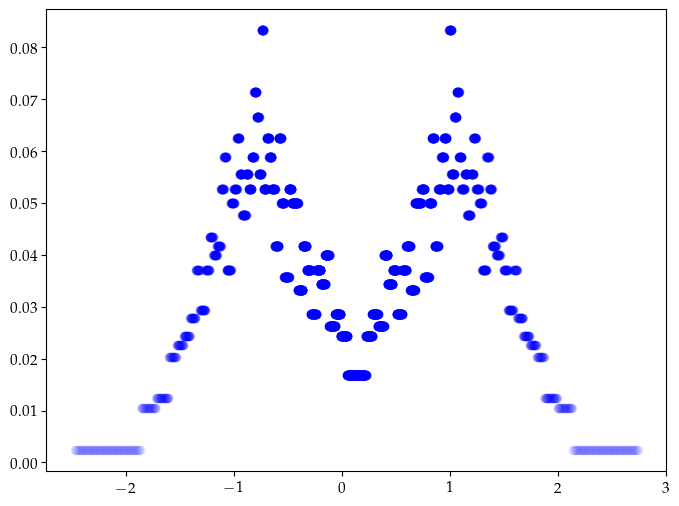

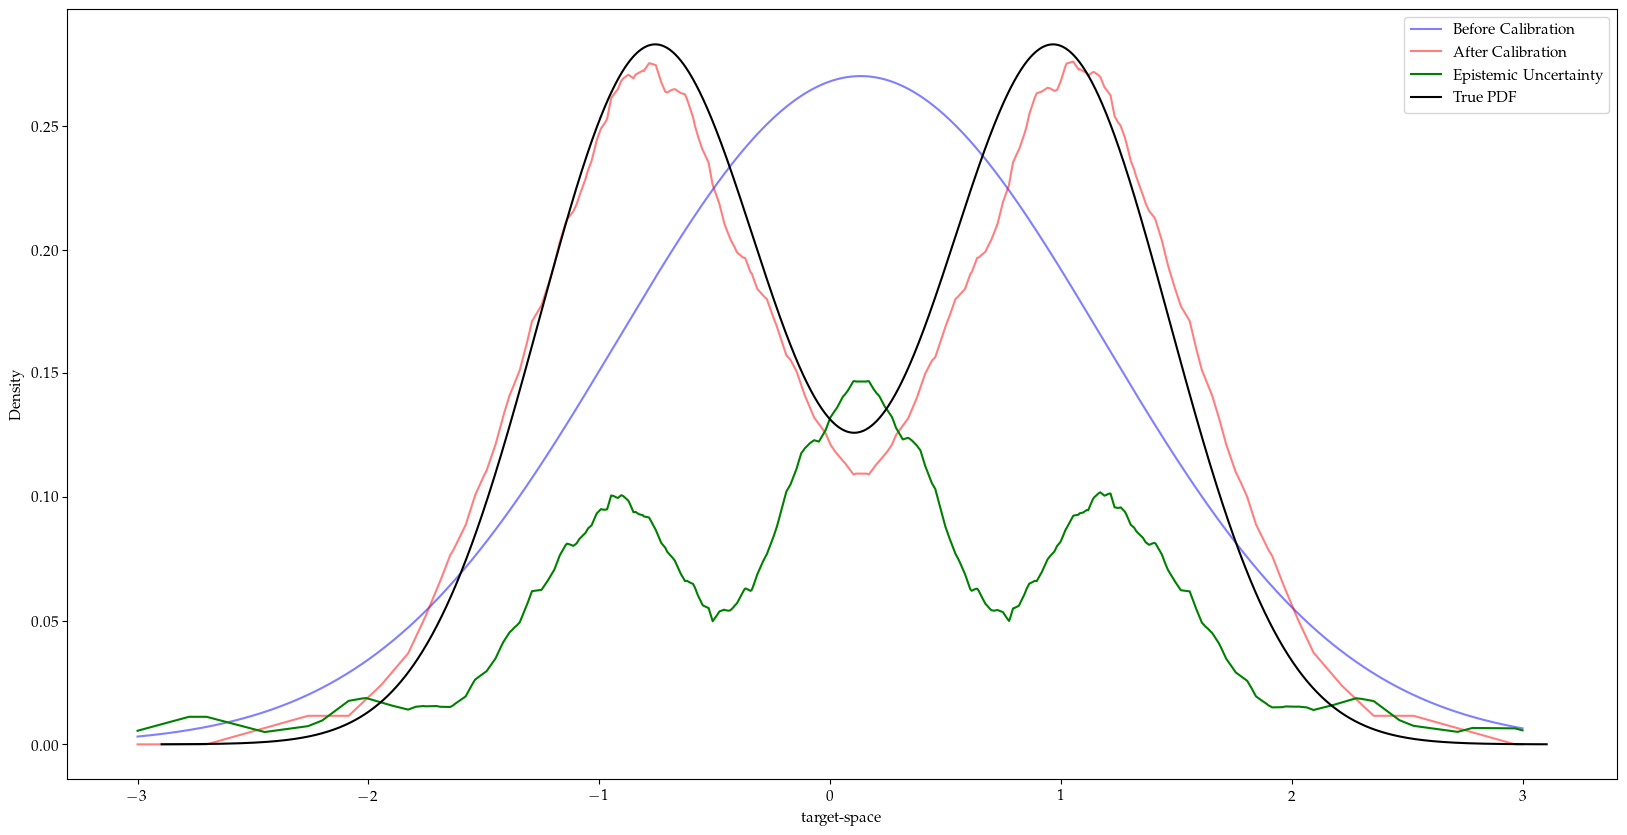

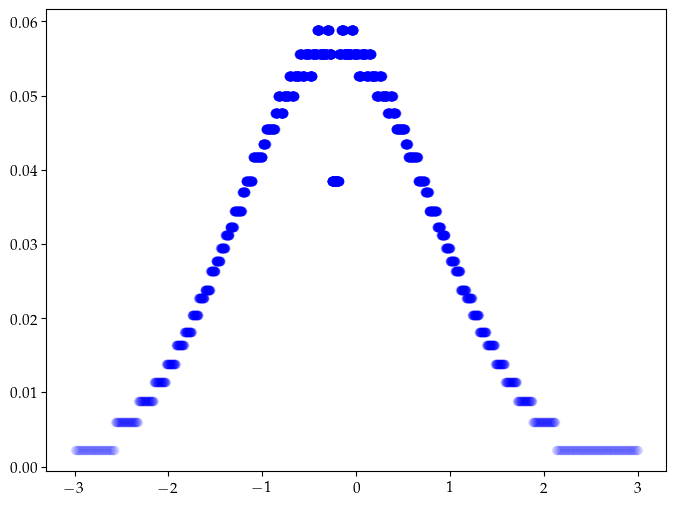

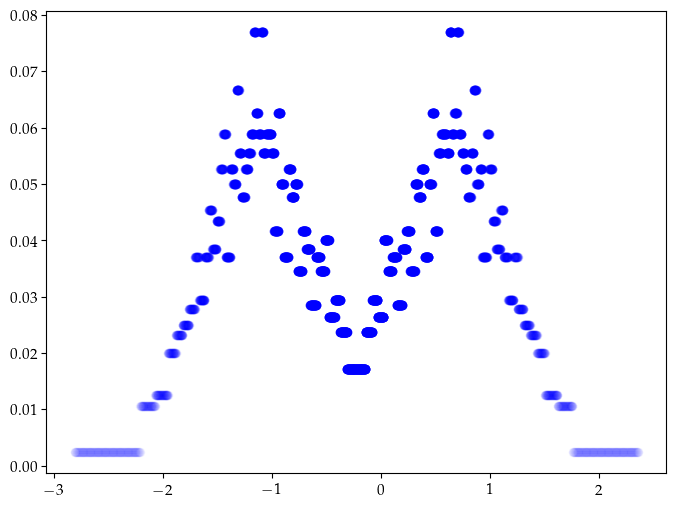

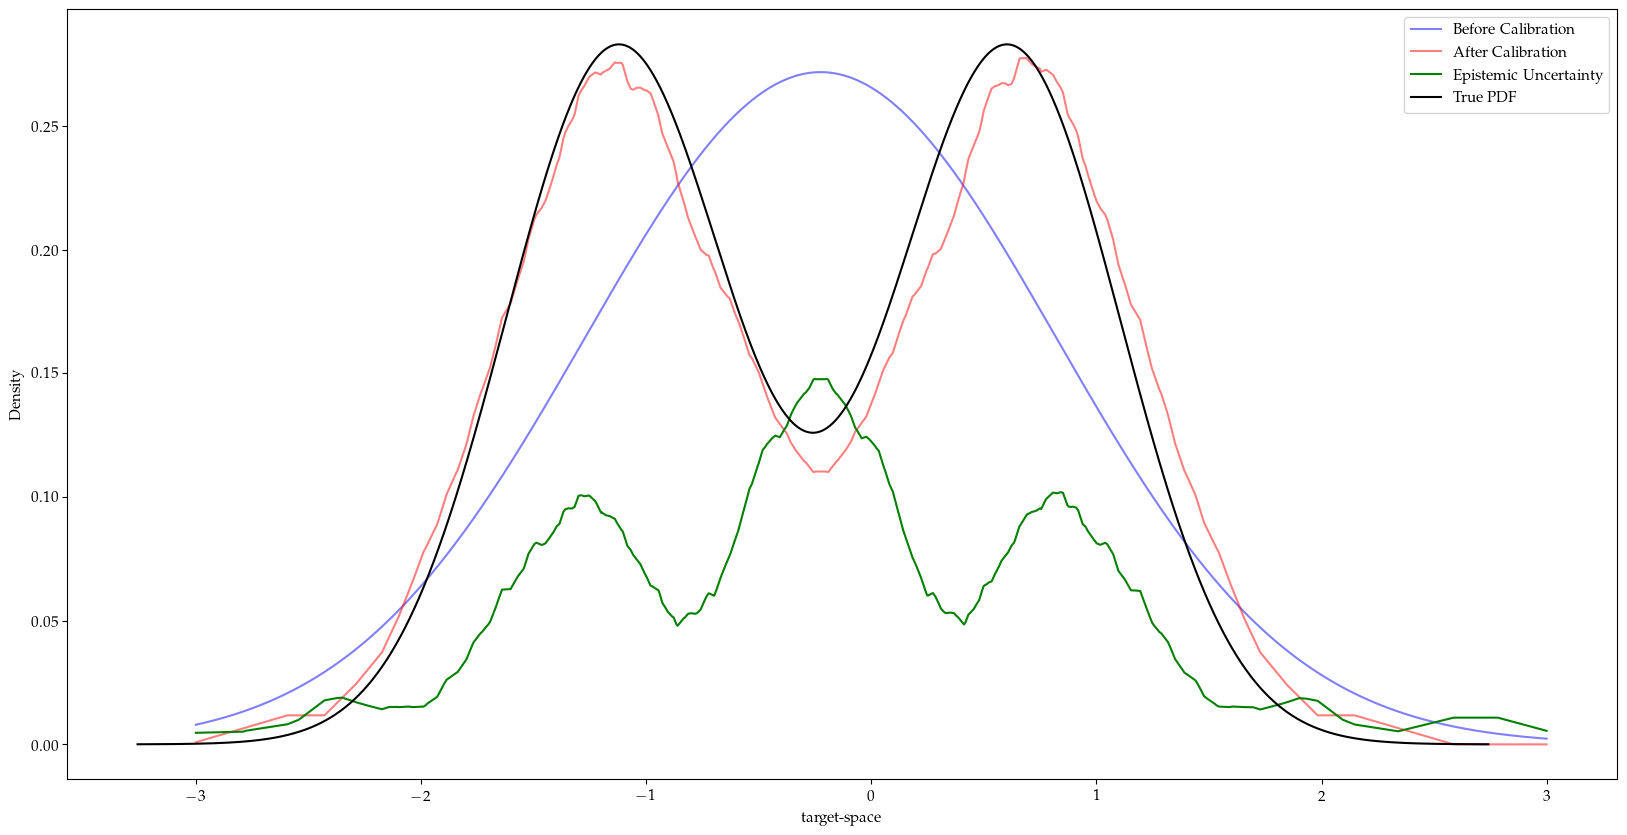

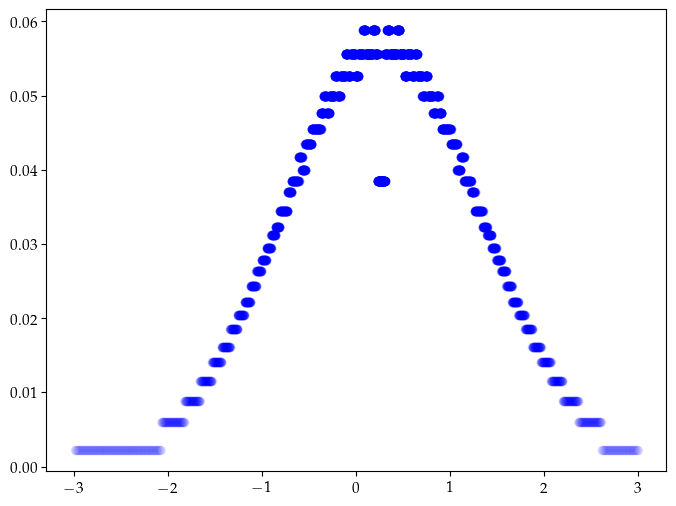

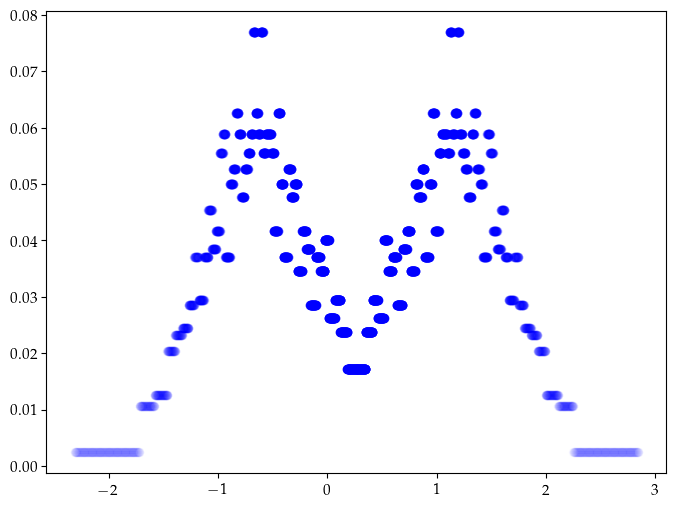

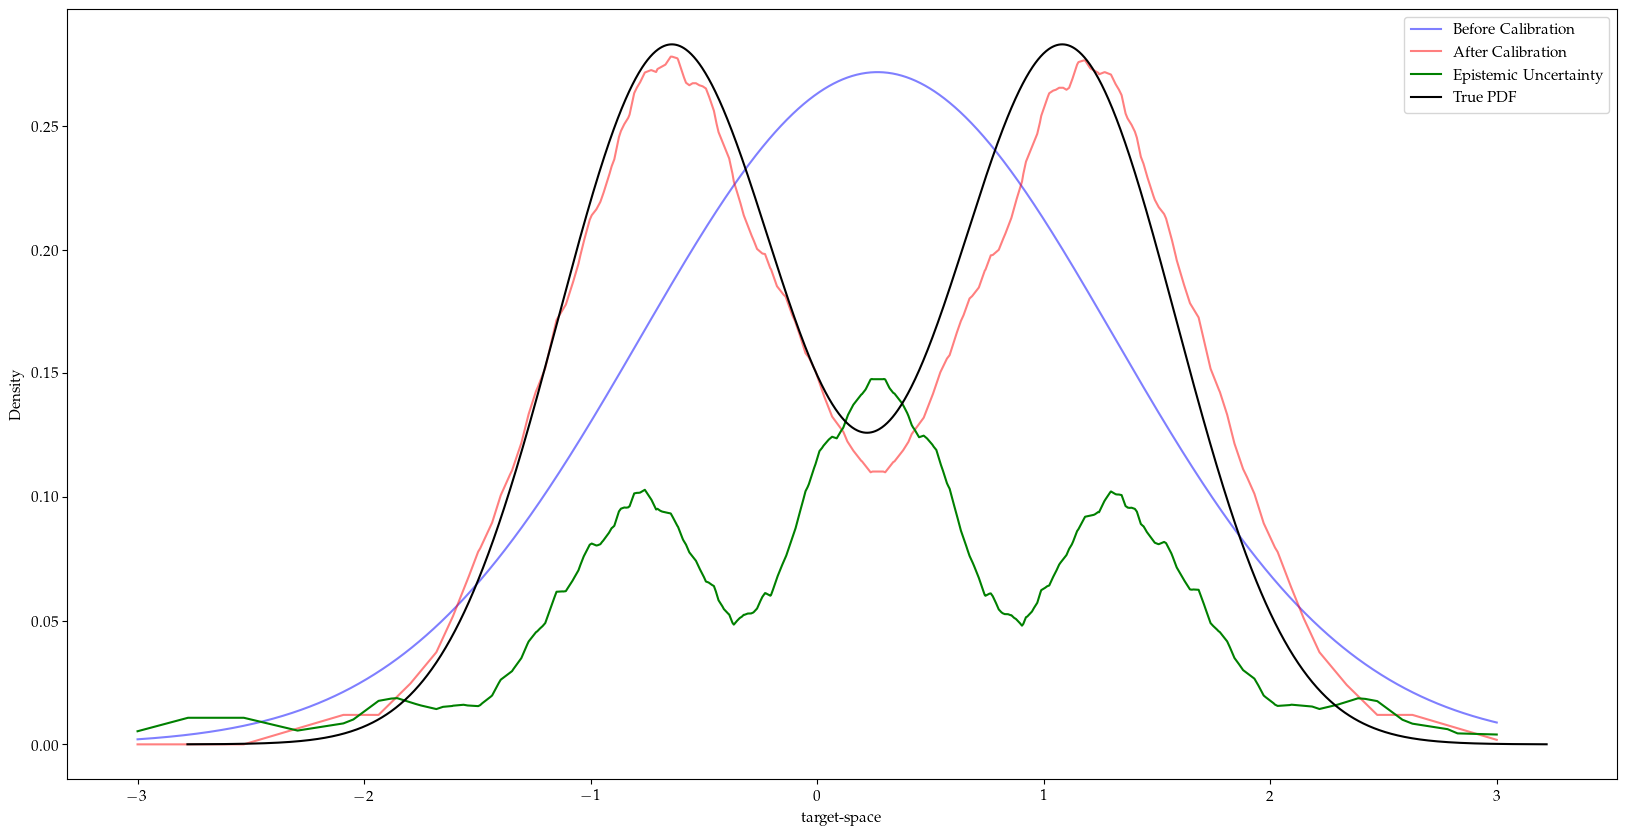

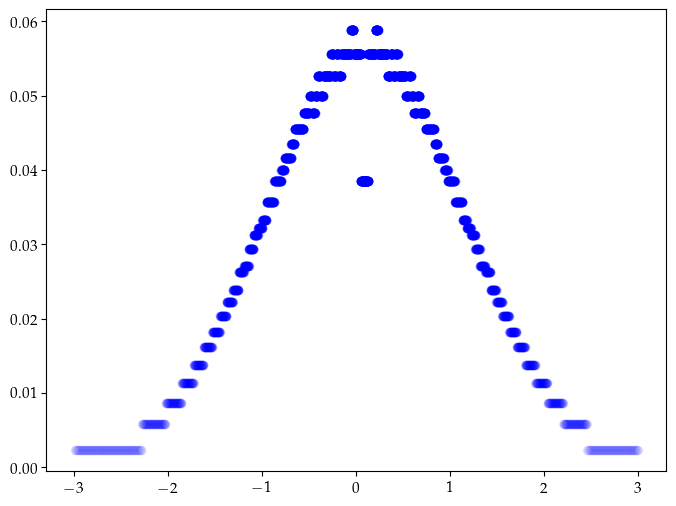

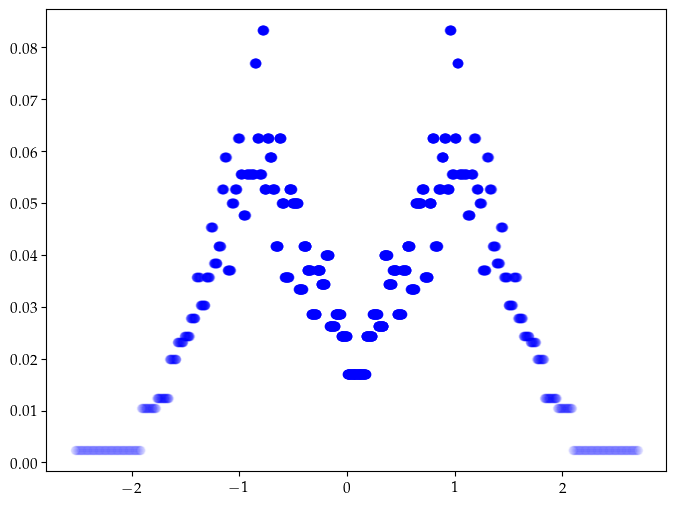

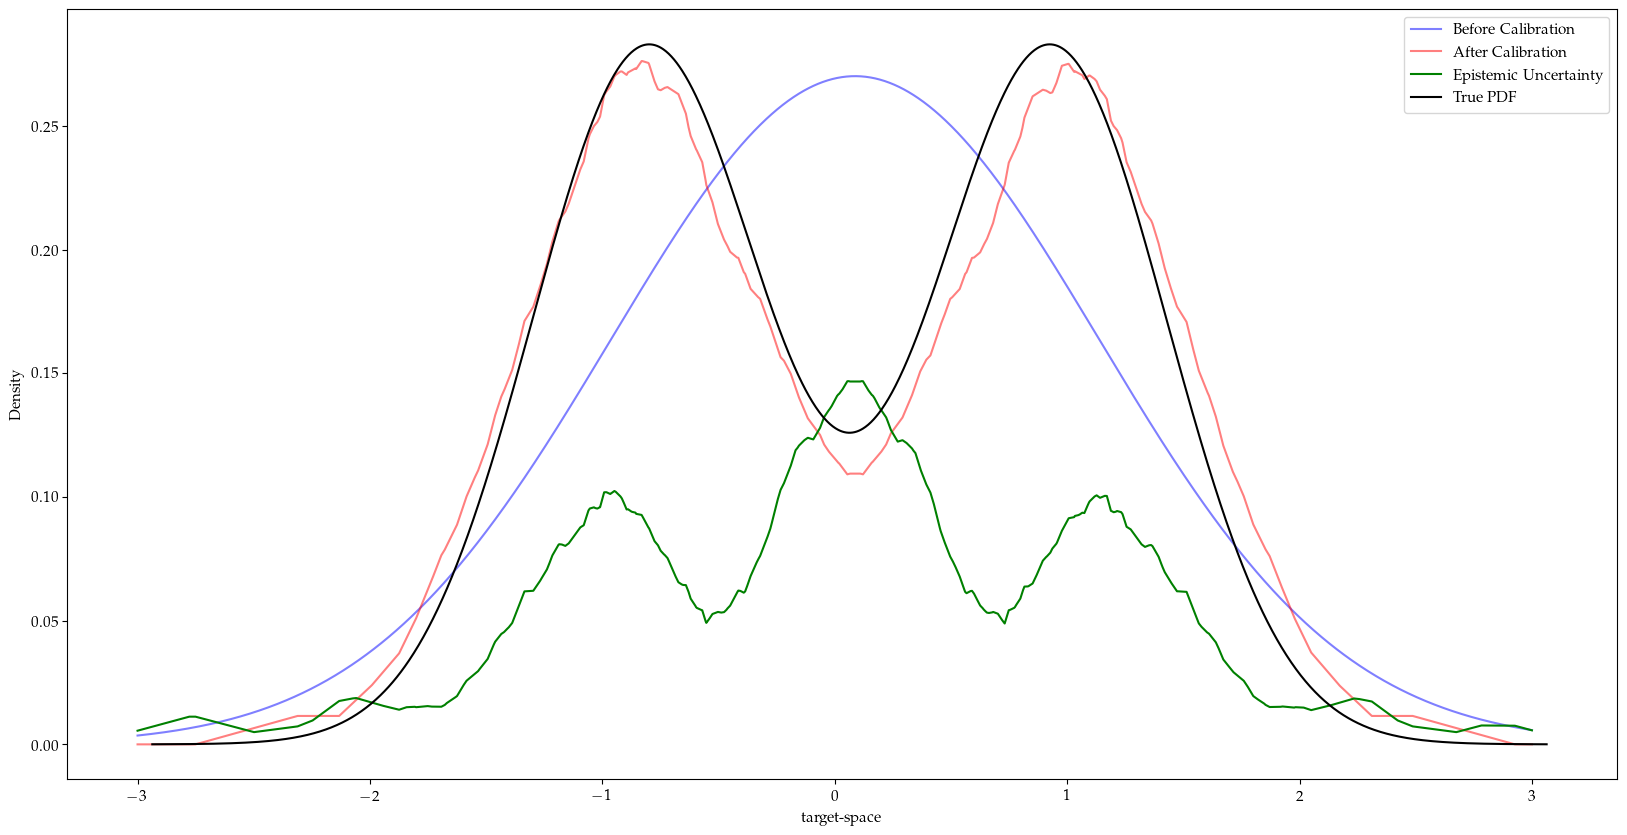

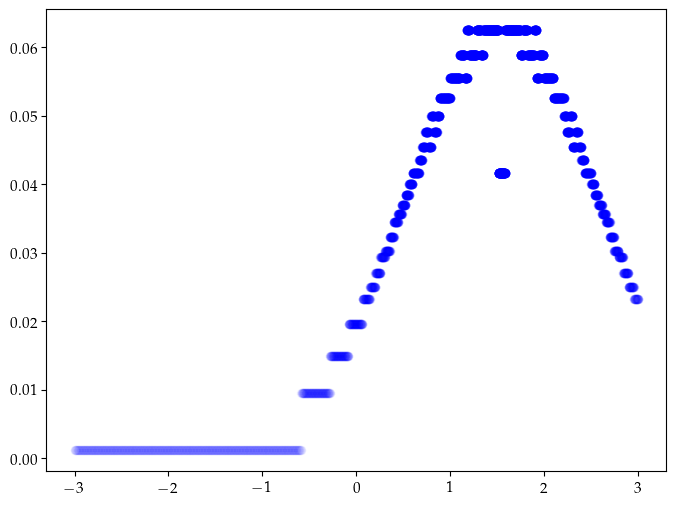

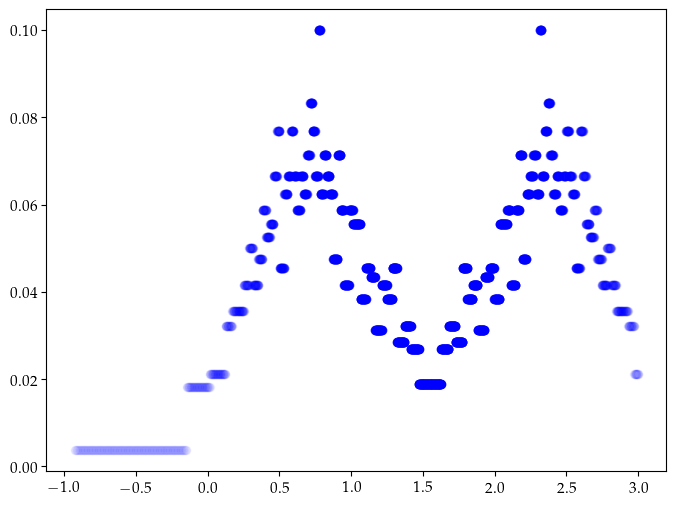

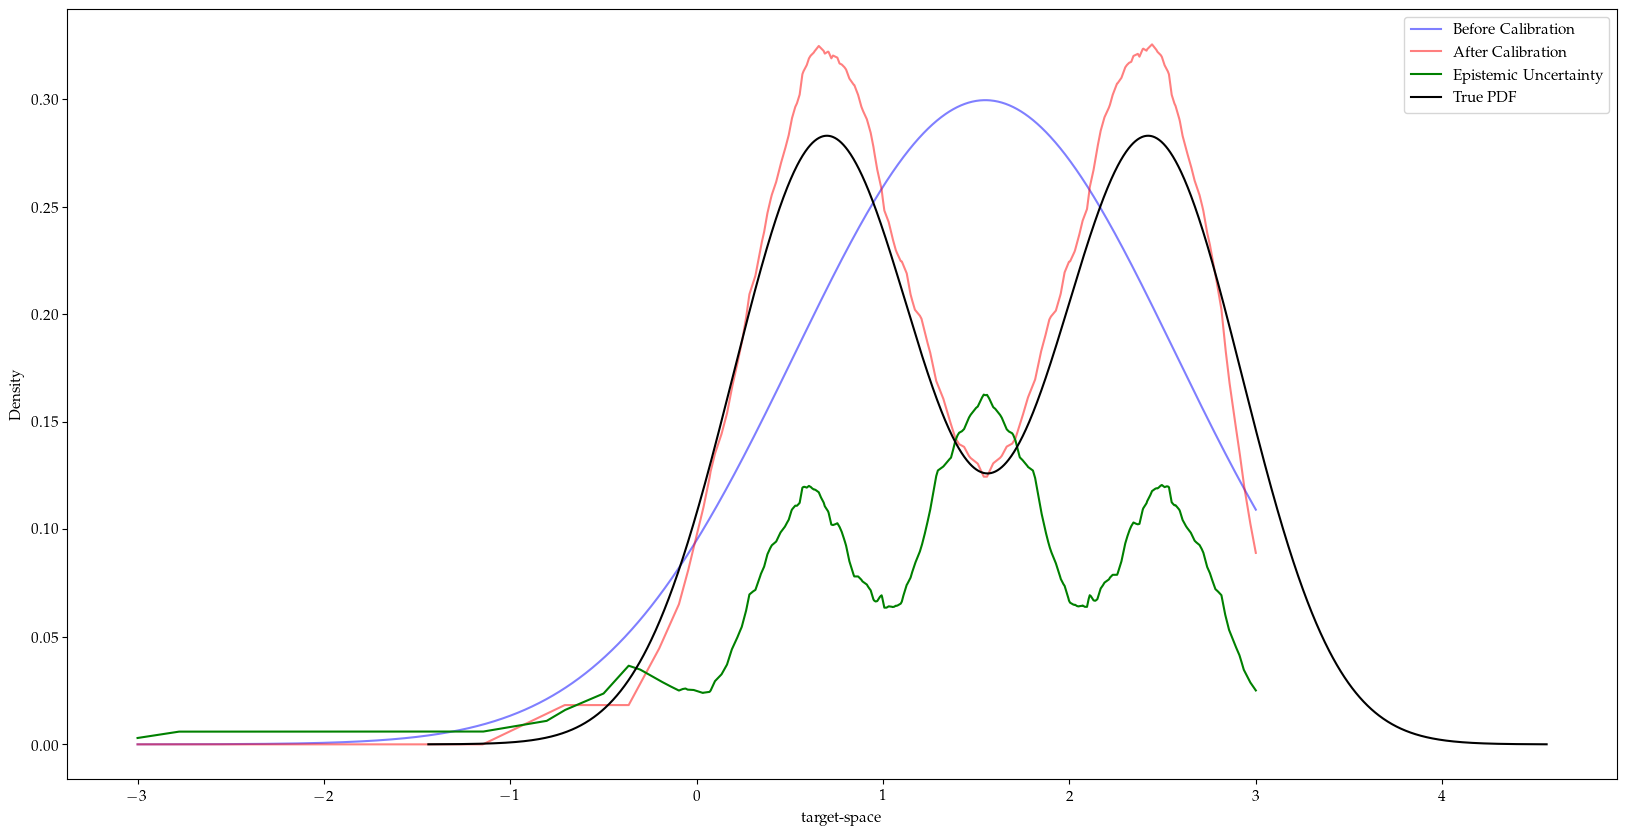

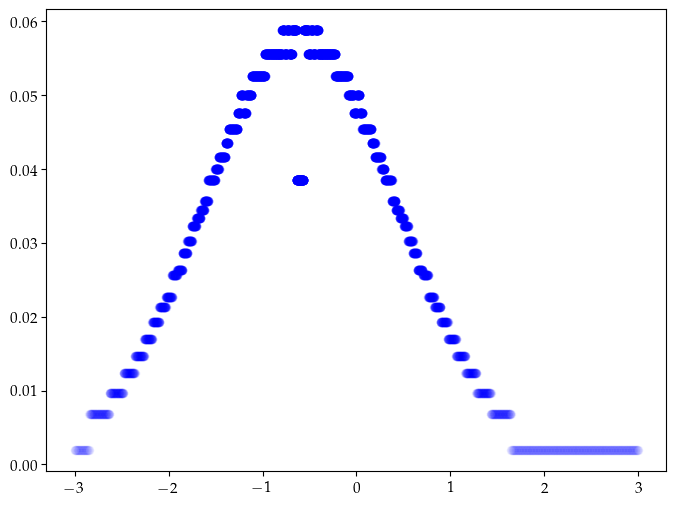

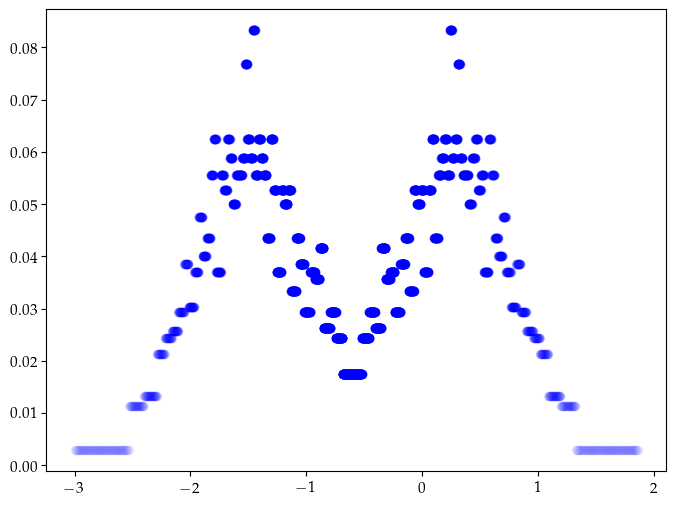

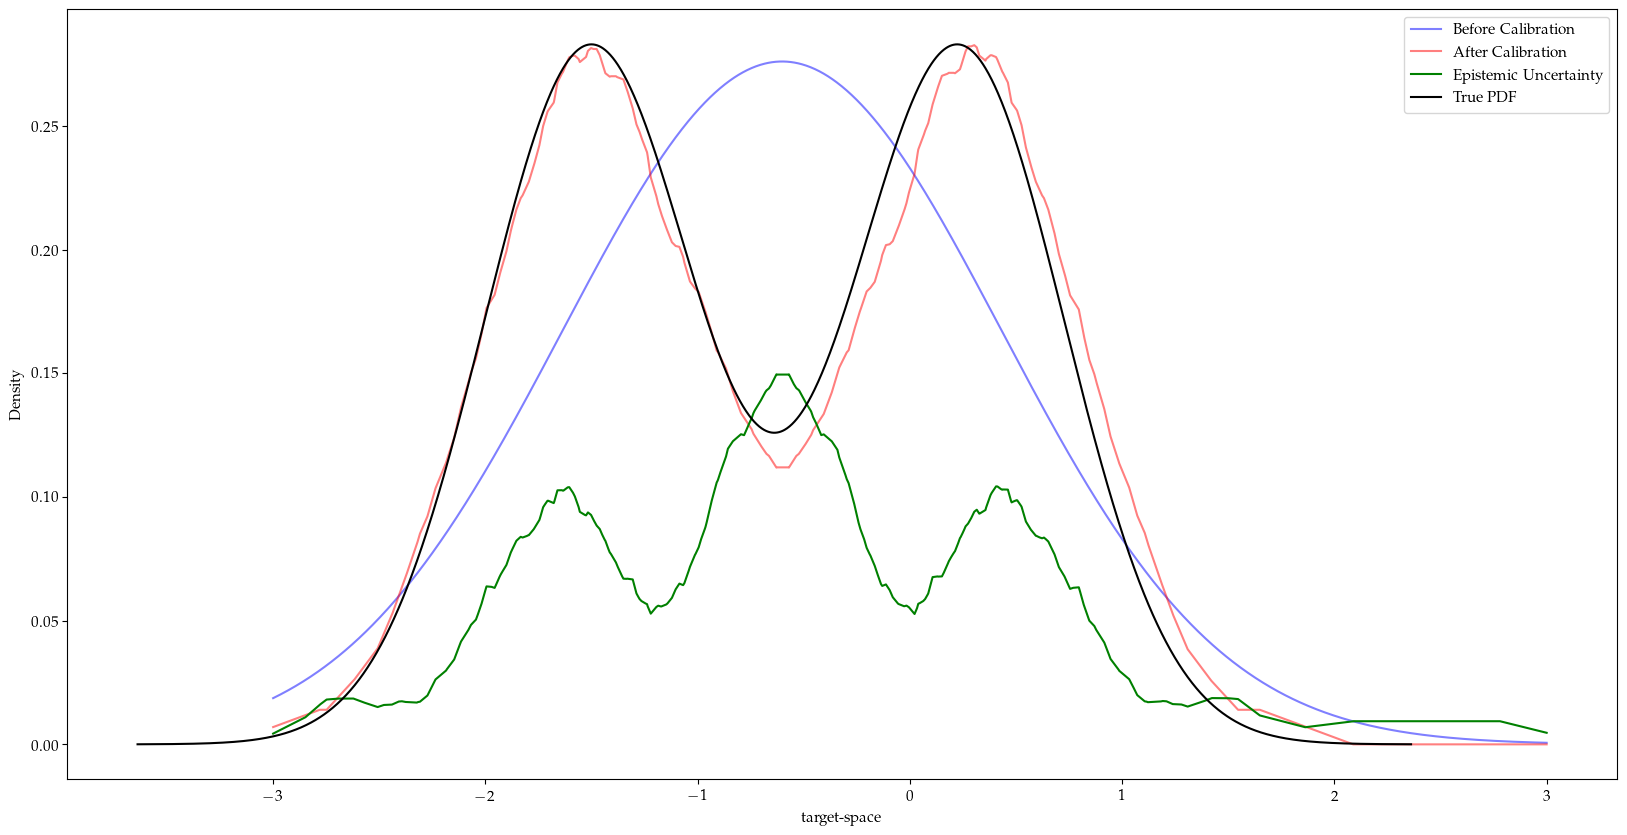

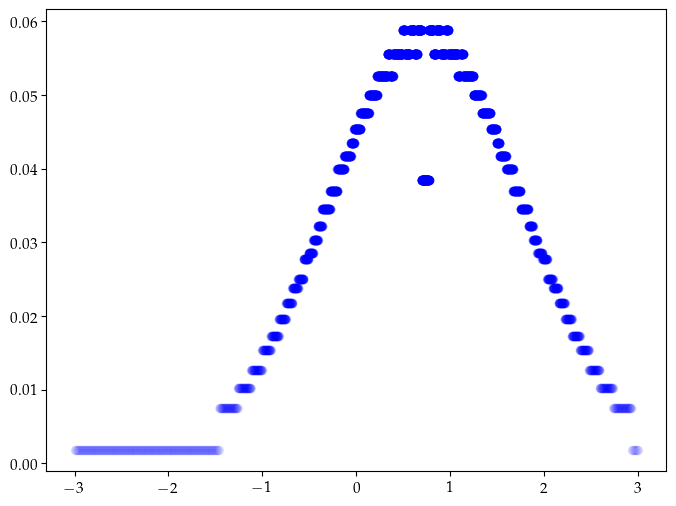

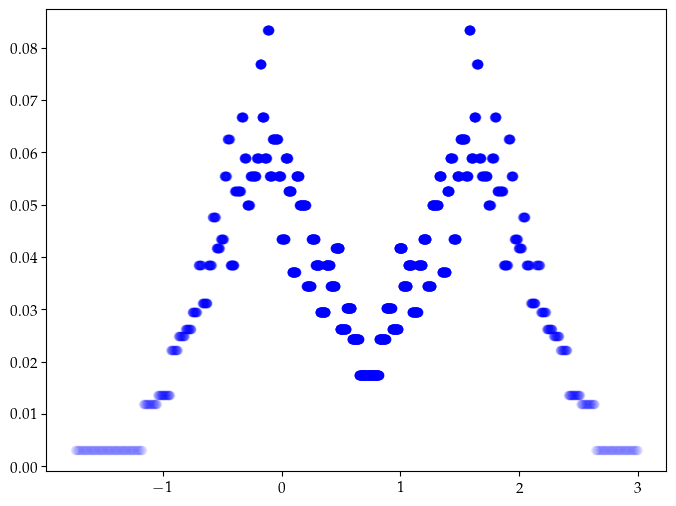

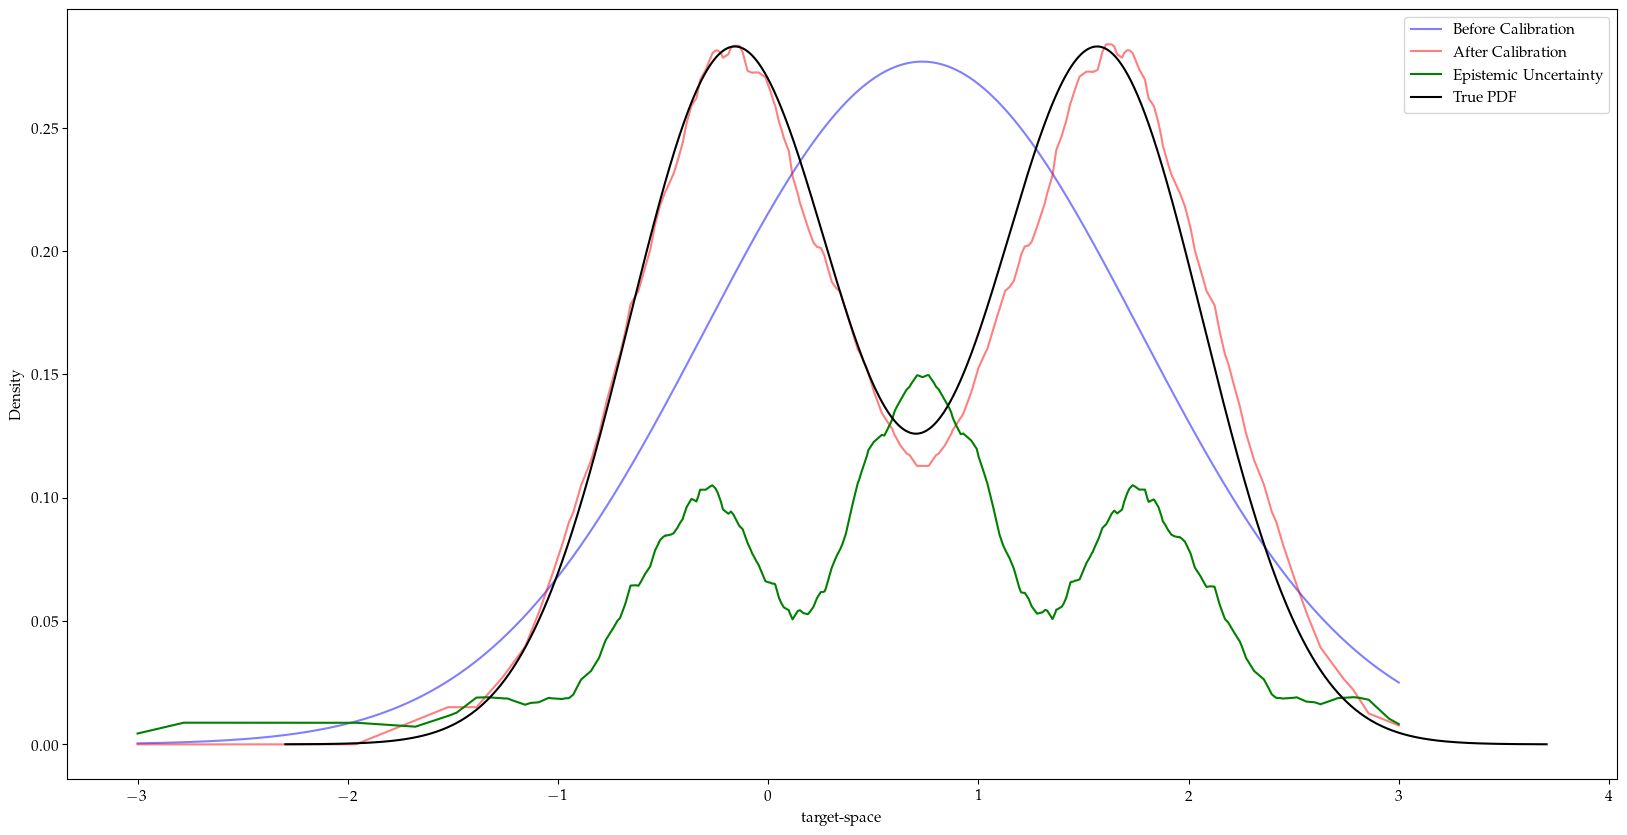

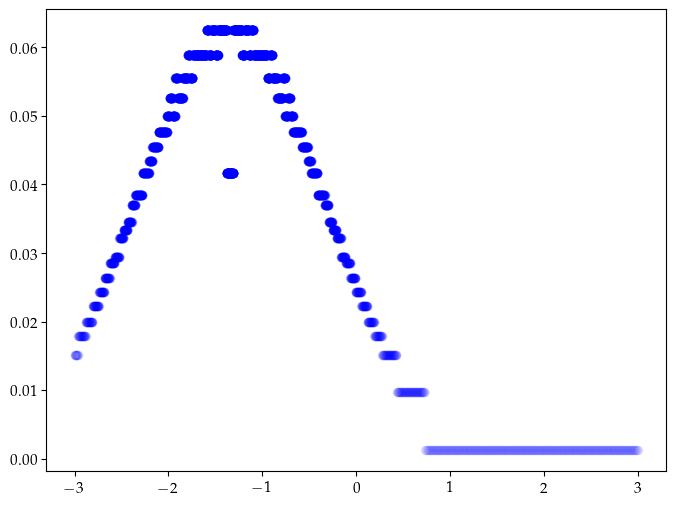

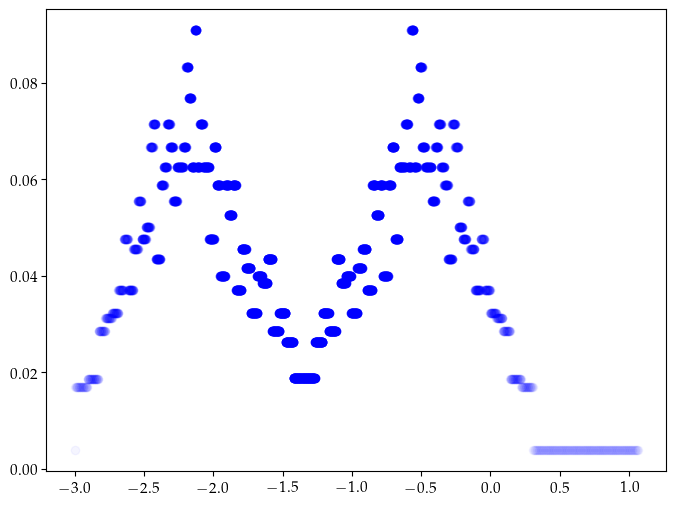

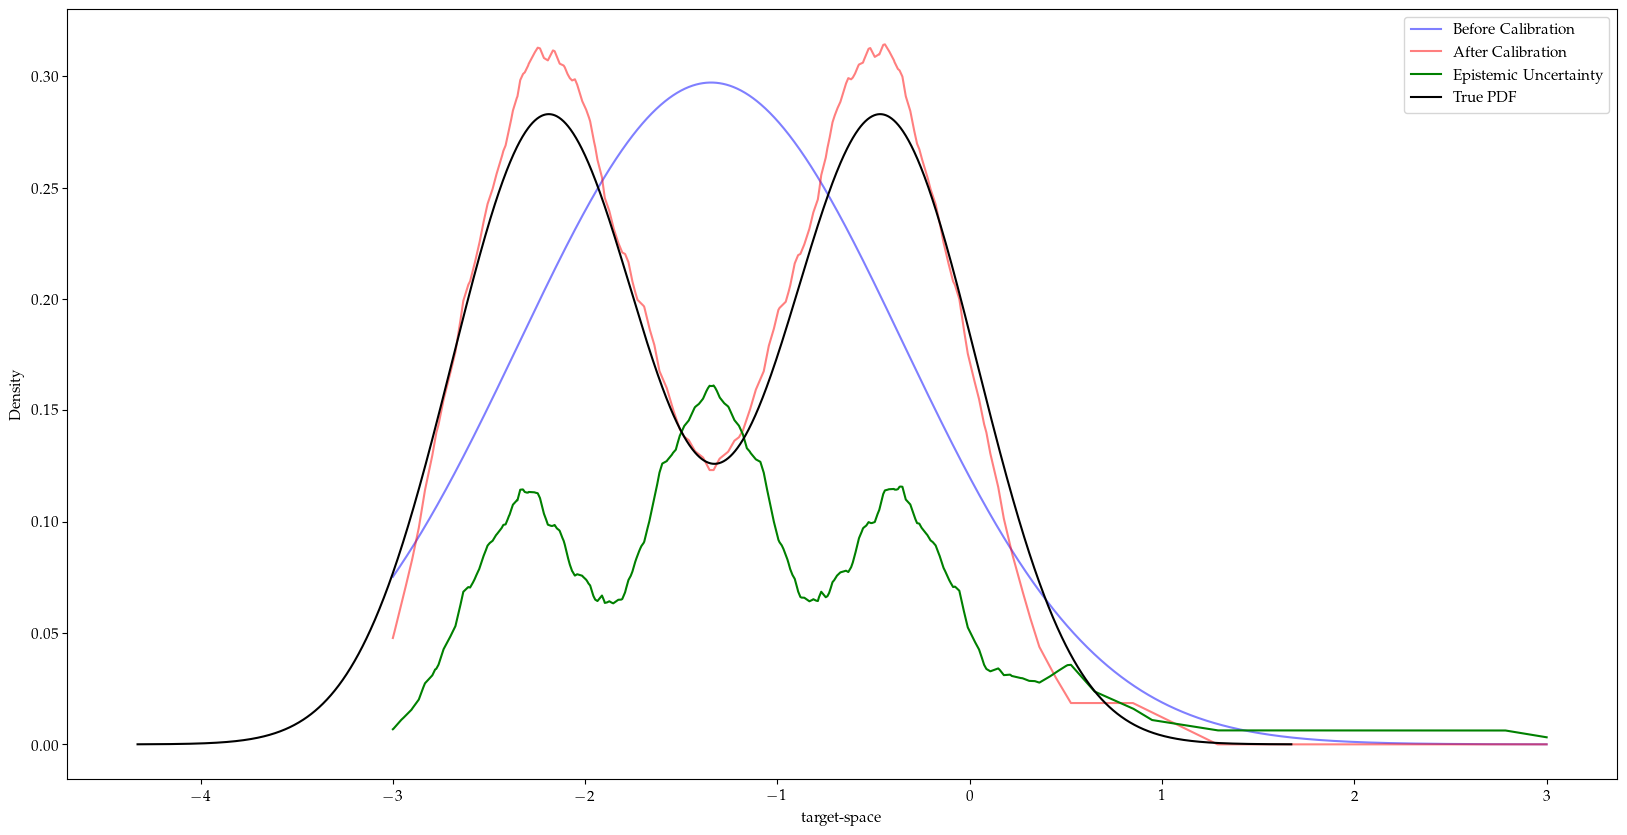

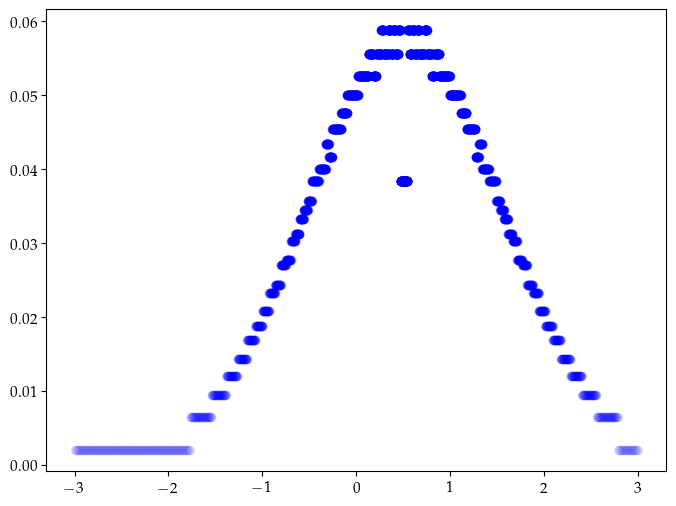

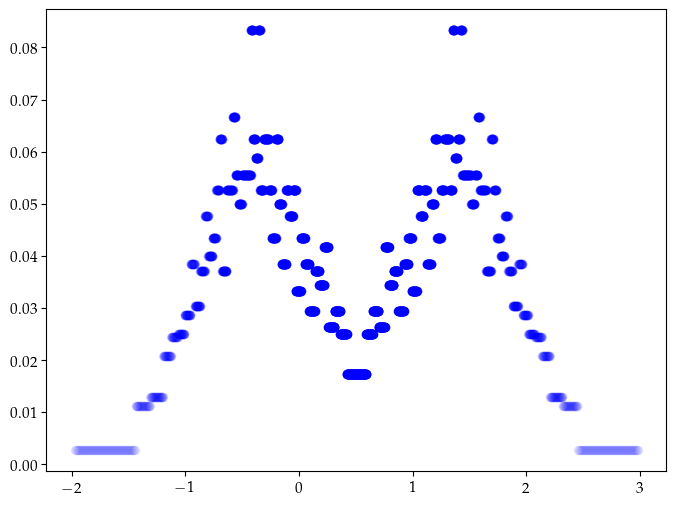

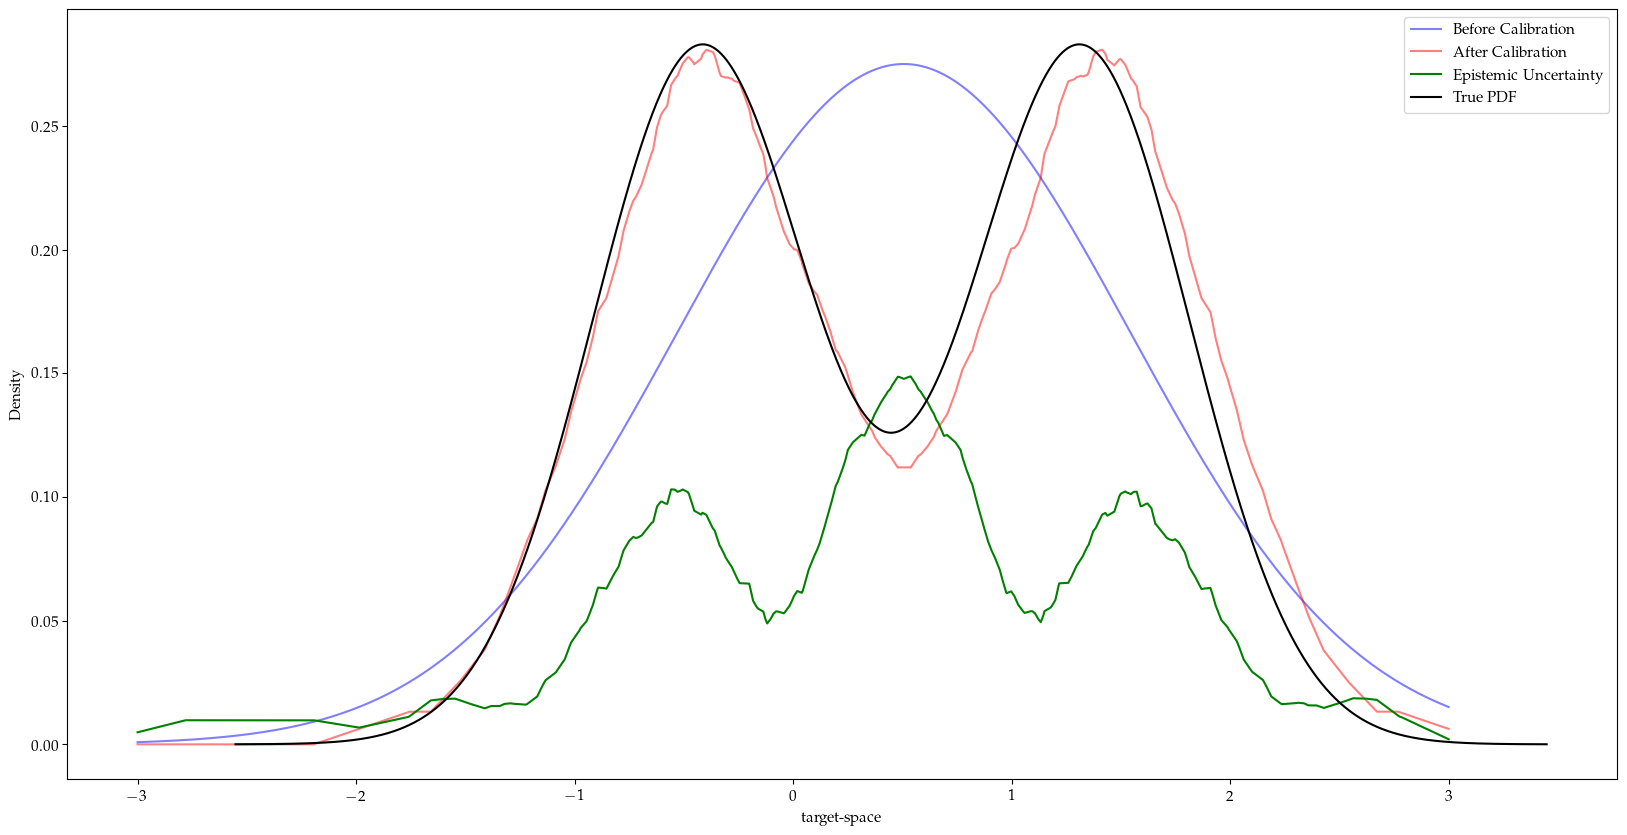

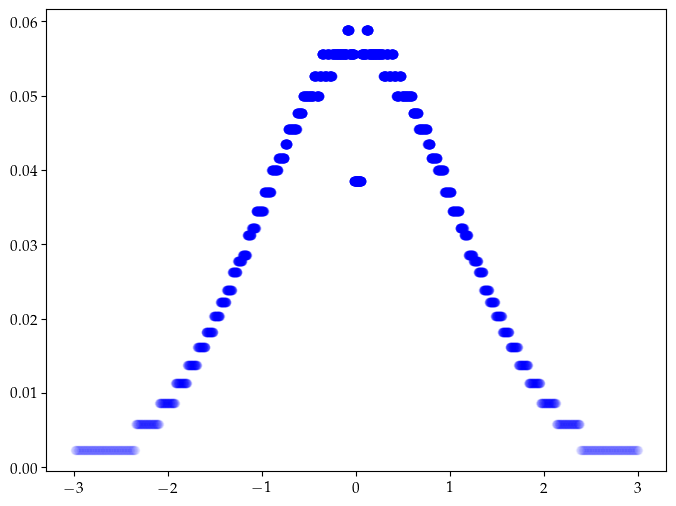

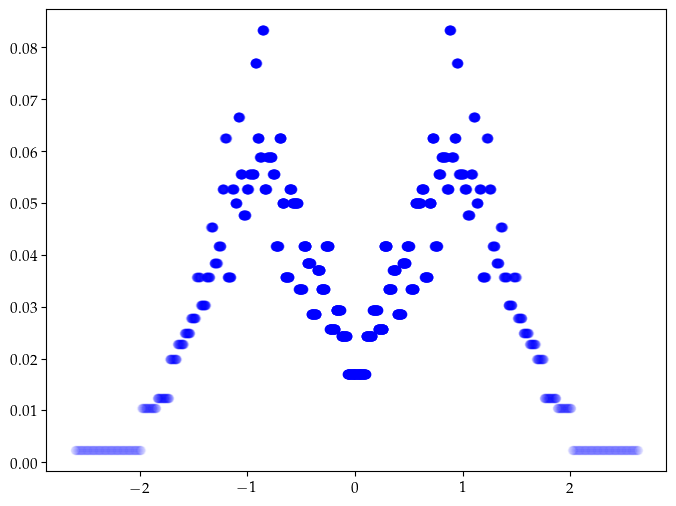

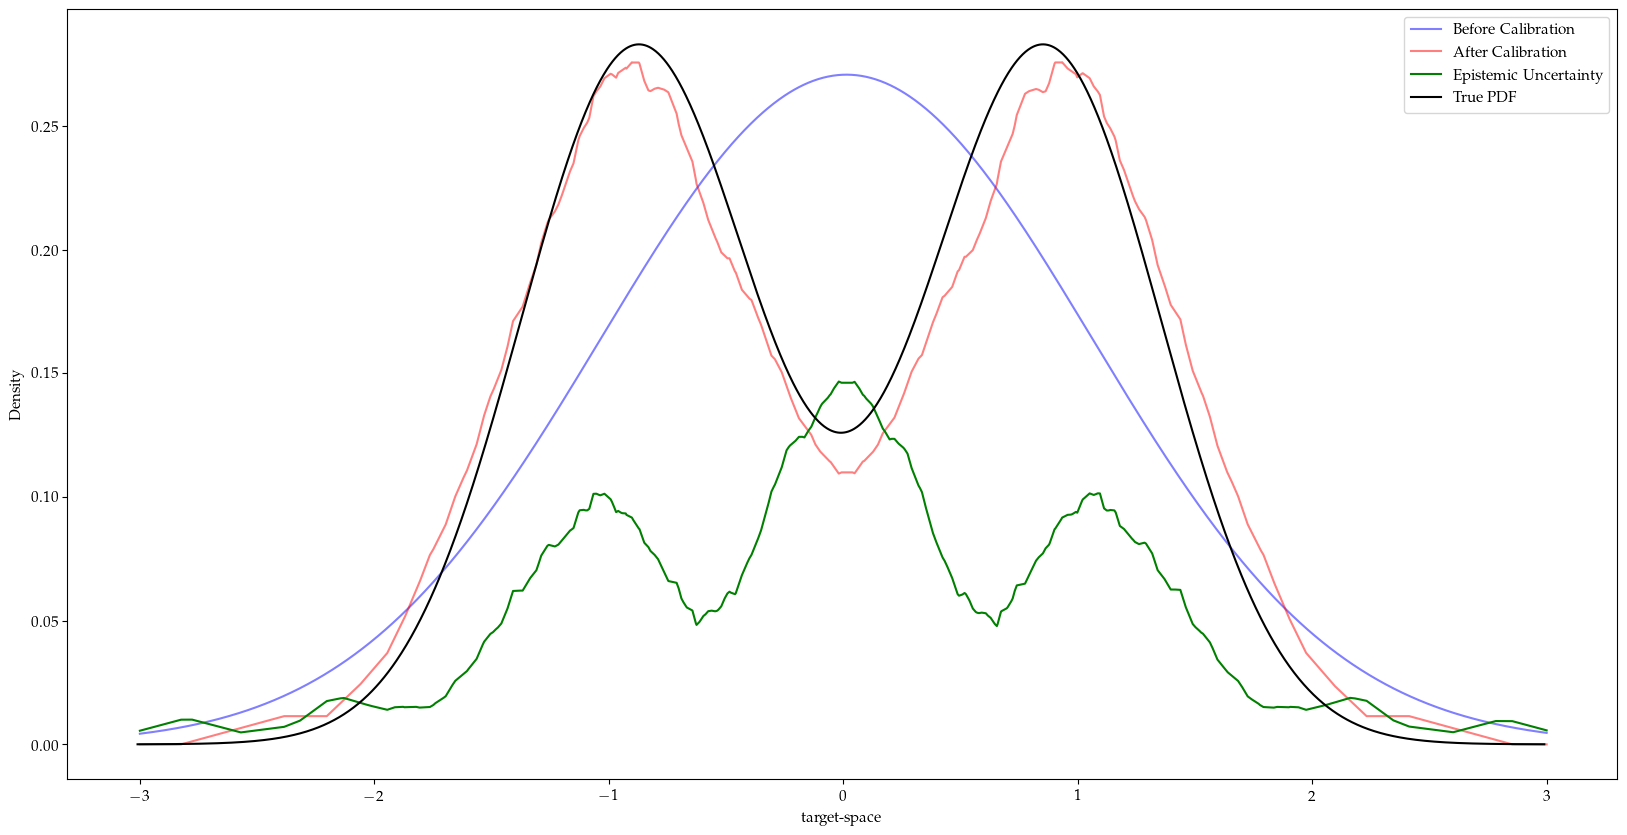

In [37]:
for sample_no in range(15):
    before, after = hdr_before[sample_no].clone().detach().numpy(), hdr_after[sample_no].clone().detach().numpy()
    density_grid_before = density_grid[sample_no].clone().detach().numpy()

    before[1:] =  np.bitwise_xor(before[1:], before[:-1])
    after[1:] =  np.bitwise_xor(after[1:], after[:-1])


    before_grid = np.zeros_like(y_space)
    after_grid = np.zeros_like(y_space)

    plt.figure(figsize=(8, 6))

    for i in range(before.shape[0]):
        i_sum = np.sum(before[i])
        if i_sum == 0:
            continue
        level = 1 / i_sum

        active_where = y_space[before[i]]
        before_grid[before[i]] = level
        plt.scatter(active_where, np.ones_like(active_where) * level, color ="blue", alpha=1- (i / before.shape[0]))

    #plt.legend()
    plt.show()

    plt.figure(figsize=(8, 6))

    for i in range(after.shape[0]):
        i_sum = np.sum(after[i])
        if i_sum == 0:
            continue
        level = 1 / i_sum

        active_where = y_space[after[i]]
        after_grid[after[i]] = level
        plt.scatter(active_where, np.ones_like(active_where) * level, color ="blue",alpha=1- (i / before.shape[0]))
    #plt.legend()
    plt.show()

    plt.figure(figsize=(20, 10))

    window_size = 150
    filter_ = np.ones(window_size) / window_size

    c_before = np.convolve(before_grid, filter_, mode='same')
    c_after = np.convolve(after_grid, filter_, mode='same')
    c_epistemic = np.convolve(np.abs(before_grid - after_grid), filter_, mode='same')

    plt.plot(y_space, scaling_factor *density_grid_before / np.sum(density_grid_before), label='Before Calibration', color='blue', alpha=0.5)
    #plt.plot(y_space, c_before / np.sum(c_before), label='Before Calibration', color='blue', alpha=0.5)
    plt.plot(y_space, scaling_factor * c_after/np.sum(c_before), label='After Calibration', color='red', alpha=0.5)
    plt.plot(y_space, scaling_factor * c_epistemic/np.sum(c_before), label='Epistemic Uncertainty', color='green')
    plt.plot(y_space+x[sample_no].item(), scaling_factor * pdf_values/np.sum(pdf_values), label='True PDF', color='black')
    plt.xlabel('target-space')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

In [51]:
y_space = np.linspace(7, 13, 1000)
pdf_values = mixture_gaussian_pdf(np.linspace(-3, 3, 1000), -k, +k, std_dev)

In [52]:
hdr_before = mdn.get_hdr(torch.tensor([[10.0]]), confidence_grid, torch.tensor(y_space))
hdr_after = mdn.get_hdr(torch.tensor([[10.0]]), calibrated_confidence_grid, torch.tensor(y_space))

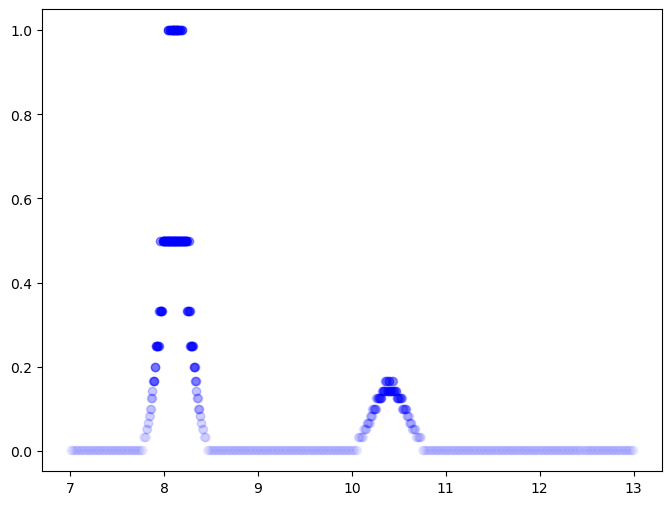

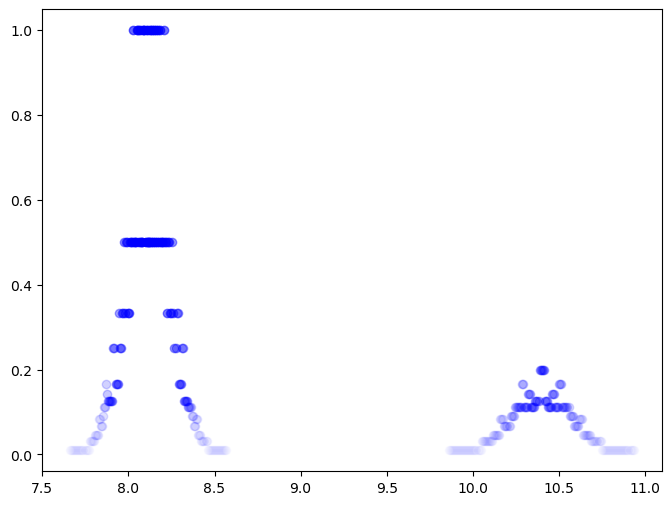

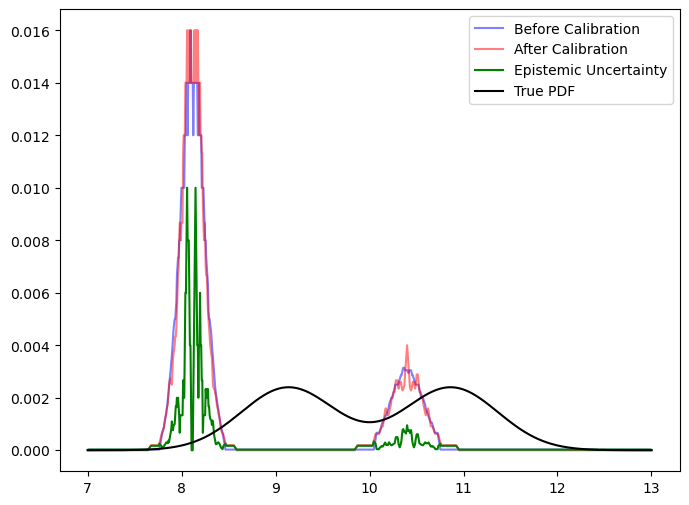

In [56]:
sample_no = 0
before, after = hdr_before[sample_no].clone().detach().numpy(), hdr_after[sample_no].clone().detach().numpy()

before[1:] =  np.bitwise_xor(before[1:], before[:-1])
after[1:] =  np.bitwise_xor(after[1:], after[:-1])


before_grid = np.zeros_like(y_space)
after_grid = np.zeros_like(y_space)

plt.figure(figsize=(8, 6))

for i in range(before.shape[0]):
    i_sum = np.sum(before[i])
    if i_sum == 0:
        continue
    level = 1 / i_sum

    active_where = y_space[before[i]]
    before_grid[before[i]] = level
    plt.scatter(active_where, np.ones_like(active_where) * level, color ="blue", alpha=1- (i / before.shape[0]))

#plt.legend()
plt.show()

plt.figure(figsize=(8, 6))

for i in range(after.shape[0]):
    i_sum = np.sum(after[i])
    if i_sum == 0:
        continue
    level = 1 / i_sum

    active_where = y_space[after[i]]
    after_grid[after[i]] = level
    plt.scatter(active_where, np.ones_like(active_where) * level, color ="blue",alpha=1- (i / before.shape[0]))
#plt.legend()
plt.show()

plt.figure(figsize=(8, 6))

window_size = 5
filter_ = np.ones(window_size) / window_size

c_before = np.convolve(before_grid, filter_, mode='same')
c_after = np.convolve(after_grid, filter_, mode='same')
c_epistemic = np.convolve(np.abs(before_grid - after_grid), filter_, mode='same')

plt.plot(y_space, c_before / np.sum(c_before), label='Before Calibration', color='blue', alpha=0.5)
plt.plot(y_space, c_after/np.sum(c_before), label='After Calibration', color='red', alpha=0.5)
plt.plot(y_space, c_epistemic/np.sum(c_before), label='Epistemic Uncertainty', color='green')
plt.plot(y_space, pdf_values/np.sum(pdf_values), label='True PDF', color='black')
plt.legend()
plt.show()

In [47]:
before, after = hdr_before[1].detach().numpy(), hdr_after[1].detach().numpy()
np.where(before[5]), np.where(after[5])

((array([305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317,
         318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330,
         331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343,
         344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356,
         357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369,
         370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382,
         383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395,
         396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408,
         409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421,
         422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434,
         435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447,
         448, 449, 450, 451, 452, 453, 454]),),
 (array([296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308,
         309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 